<a href="https://colab.research.google.com/github/francescomazzolin/RTS2/blob/main/GRAPH_IBM_AML_LI_SMALL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparatory work

#### Importing the packages

In [1]:
#Data ingestion
import pickle
import gzip

#General purpose
import pandas as pd
import numpy as np
import scipy.stats as stats
import math


#Plotting styles
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from matplotlib_venn import venn2
import matplotlib_venn as venn
import matplotlib.patches as mpatches
import seaborn as sns

#Graph Part
import networkx as nx

#Other
import time

#### Plotting Styles

Global styling

In [2]:
# Apply the seaborn style with a white grid
sns.set(style='whitegrid')

# Customize global matplotlib settings for a professional look
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'lines.linewidth': 2,
    'legend.fontsize': 12,
        'font.family': 'sans-serif',
    'font.sans-serif': ['DejaVu Sans'],  # Use a professional font
})

muted_palette = sns.color_palette("muted")
blueish_color = muted_palette[0]
reddish_color = muted_palette[3]

#### Plotting functions

In [3]:
def plot_pie_chart(data, title, color_dict=None, legend_title="Currencies < 2.5%"):
    """
    Plots a pie chart with colors assigned from a dictionary and a customizable legend title.

    Parameters:
    - data (pd.Series): Data for the pie chart (index = labels, values = sizes).
    - title (str): Title of the pie chart.
    - color_dict (dict, optional): Dictionary mapping category labels to colors.
    - legend_title (str): Title of the legend for small categories.
    """

    # Define threshold for "Other" category
    threshold = 2.5

    # Compute percentage shares
    total = data.sum()
    percentages = (data / total) * 100

    # Separate main and "Other" categories
    main_slices = percentages[percentages >= threshold]
    other_slices = percentages[percentages < threshold]

    # Add "Other" category if applicable
    if not other_slices.empty:
        main_slices["Other"] = other_slices.sum()

    # Assign colors based on the provided dictionary
    if color_dict:
        colors = [color_dict.get(category, "#d3d3d3") for category in main_slices.index]  # Default gray for missing keys
        other_colors = [color_dict.get(category, "#d3d3d3") for category in other_slices.index]  # Match legend colors
    else:
        colors = sns.color_palette("muted", len(main_slices))
        other_colors = sns.color_palette("muted", len(other_slices))

    # Plot pie chart
    plt.figure(figsize=(8, 8))
    wedges, texts, autotexts = plt.pie(
        main_slices, labels=main_slices.index, autopct='%1.1f%%',
        startangle=90, counterclock=False, colors=colors
    )

    # Add legend for small categories with matching colors
    if not other_slices.empty:
        legend_patches = [mpatches.Patch(color=other_colors[i], label=f"{idx}: {val:.1f}%")
                          for i, (idx, val) in enumerate(other_slices.items())]
        plt.legend(handles=legend_patches, title=legend_title, loc="best", fontsize=10)

    plt.title(title)
    plt.show()




def scatter_transaction_connectivity_ratio(cleaned_nodes_df, title, outlier = False , n_outlier = 0, color = blueish_color):
  plt.figure(figsize=(10, 6))
  plt.scatter(cleaned_nodes_df['Transactions'], cleaned_nodes_df['Connectivity_Ratio'],
              color=color, alpha=0.5, edgecolors='k')  # Change 'blue' to any color you like

  # Labels and Title
  plt.xlabel('Transactions')
  plt.ylabel('Connectivity Ratio')
  plt.title(f'Scatter Plot of {title.title()} Transactions vs Connectivity Ratio - Minus Top {remove_outliers_number} Accounts by Activity')

  # Show Grid
  plt.grid(True, linestyle='--', alpha=0.6)

  # Display the plot
  plt.show()

#### Other functions imported from Preliminary Exploratory Data Analysis

In [4]:
def accounts_type(df, category = '', large = False, role = False ):

    """
    The purpose of this function is, from a given transaction dataframe, to
    create the set of accounts that generated
    """

    #This will obtain a numpy.ndarray of the account number of RECEIVING accounts inside the given subset
    #of data we are considering. From it we obtain a set
    df_sending_accounts = set ( df['Account'].unique() )

    #This will obtain a numpy.ndarray of the account number of SENDING accounts inside the given subset
    #of data we are considering
    df_receiving_accounts = set( df['Account.1'].unique() )

    print('*'*100)
    print(f'{category.upper()} ACCOUNTS')
    print(f'\nThe number of {category} SENDING df accounts is: {len(df_sending_accounts)}')
    print(f'\nThe number of {category} RECEIVING accounts is: {len(df_receiving_accounts)}')

    #This will obtain the intersection between the two sets, thus obtaining the accounts that appeared as
    #both receiving and sending accounts in the dataset
    df_both_accounts = df_sending_accounts & df_receiving_accounts
    print(f'\nThe number of {category} accounts involved on BOTH SIDES of df transactions is: {len(df_both_accounts)}')

    total_accounts = df_sending_accounts | df_receiving_accounts
    # #To obtain the total number of accounts we use the union of the two sets of accounts, thereby removing the
    # print(f'\nFor a total number of {category} accounts equal to: {total_accounts}')

    # only_receiving = len(df_receiving_accounts - df_both_accounts)
    # only_sending = len(df_sending_accounts - df_both_accounts)
    # both = len(df_both_accounts)

    # # plt.figure(figsize=(5,5))
    # # venn = venn3(subsets=(only_receiving, only_sending, both, 0, 0, 0, 0),
    # #              set_labels=('Receiving', 'Sending', 'Both'))

    # # # Show the plot
    # # plt.show()

    # #NEw
    # plt.figure(figsize=(12,12))
    # venn_diagram = venn3(
    #     subsets=(only_receiving, only_sending, both, 0, 0, 0, 0),
    #     set_labels=('Receiving', 'Sending', 'Both')
    # )

    # # Adjust set label positions
    # labelA, labelB, labelC = venn_diagram.set_labels
    # if labelA:
    #     labelA.set_position((-0.6, 0.1))
    # if labelB:
    #     labelB.set_position((0.6, 0.1))
    # if labelC:
    #     labelC.set_position((0.0, -0.2))

    # # Tweak font
    # for lbl in venn_diagram.set_labels:
    #     if lbl:
    #         lbl.set_fontsize(12)
    #         lbl.set_weight("bold")

    # #plt.title(f'{category.title()} Accounts by Role')
    # #plt.text(f"The intersection represents the {(both / len(total_accounts)) * 100:.4f}% of the accounts")

    # if large:

    #     y = 0.85

    # else:

    #     y = 0.75

    # plt.suptitle(
    # f"{category.title()} Accounts by Role\n"
    # f"The intersection represents the {(both / len(total_accounts)) * 100:.4f}% of the accounts",
    # fontsize=12,
    # y=y
    # )
    # plt.show()

    if role:

      return df_sending_accounts, df_receiving_accounts, df_both_accounts, total_accounts

    elif not role:

      return total_accounts

## Ingesting the data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# df_augmented = pd.read_pickle('drive/MyDrive/parsed_ibm_aml.pkl')

file_path = "/content/drive/My Drive/parsed_ibm_aml.pkl.gz"

with gzip.open(file_path, "rb") as f:
    df_augmented = pickle.load(f)


### Train-Val-Test Split

In [7]:
"""
First we apply a train-val-test split to the dataset.

Using the following suggestion from the Kaggle Page of the dataset:

However, each of the six individual datasets can be subset chronologically
for train, validate, and test.
We have found a 60% / 20% / 20% division to be effective, and
encourage others to follow this division.

We proceed with a 60-20-20 split
"""

# training_index = int(0.6 * df_augmented.shape[0])
# print(f'The training dataset will involve: {training_index + 1} transactions,  which is {((training_index + 1) / df_augmented.shape[0]*100):.2f}% of the dataset')

# training_data = df_augmented.iloc[:training_index, : ]

# test_index = int(0.8 * df_augmented.shape[0])
# validation_data = df_augmented.iloc[training_index:test_index, : ]
# print(f'The training dataset will involve: {validation_data.shape[0]} transactions, which is {(validation_data.shape[0] / df_augmented.shape[0]*100):.2f}% of the dataset')

# test_data = df_augmented.iloc[test_index:, : ]
# print(f'The training dataset will involve: {test_data.shape[0]} transactions, which is {(validation_data.shape[0] / df_augmented.shape[0]*100):.2f}% of the dataset')



'\nFirst we apply a train-val-test split to the dataset.\n\nUsing the following suggestion from the Kaggle Page of the dataset:\n\nHowever, each of the six individual datasets can be subset chronologically\nfor train, validate, and test.\nWe have found a 60% / 20% / 20% division to be effective, and\nencourage others to follow this division.\n\nWe proceed with a 60-20-20 split\n'

### Selecting the data

Our dataset for the analysis will be constricted to the training set

In [8]:
data = df_augmented

In [9]:
len(data[data['Is Laundering'] == 1])

3565

Check:

For the LI-Small_Trans.csv data card: 3.565 frauds should be present

## Additional EDA

### Forex

In [14]:
# df_augmented = pd.read_pickle('drive/MyDrive/parsed_ibm_aml.pkl')
import pickle
file_path = '/content/forex_data.pkl'

with open(file_path, "rb") as f:
    forex_df = pickle.load(f)


forex_df['USD'] = [1] * len(forex_df)
data['Date'] = data['Timestamp'].dt.floor('D')

currency_dict = {
    "US Dollar": "USD",
    "Euro": "EUR",
    "Yuan": "CNY",
    "Saudi Riyal": "SAR",
    "Rupee": "INR",
    "Bitcoin": "BTC",
    "Yen": "JPY",
    "Canadian Dollar": "CAD",
    "Australian Dollar": "AUD",
    "Brazil Real": "BRL",
    "Shekel": "ILS",
    "Swiss Franc": "CHF",
    "UK Pound": "GBP",
    "Ruble": "RUB",
    "Mexican Peso": "MXN"
}

currencies_list = list(data['Payment Currency'].unique())

<ipython-input-14-de5f49312559>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  forex_df = pickle.load(f)


In [15]:
# df_augmented = pd.read_pickle('drive/MyDrive/parsed_ibm_aml.pkl')
import pickle
file_path = '/content/forex_data.pkl'

with open(file_path, "rb") as f:
    forex_df = pickle.load(f)


forex_df['USD'] = [1] * len(forex_df)
data['Date'] = data['Timestamp'].dt.floor('D')

currency_dict = {
    "US Dollar": "USD",
    "Euro": "EUR",
    "Yuan": "CNY",
    "Saudi Riyal": "SAR",
    "Rupee": "INR",
    "Bitcoin": "BTC",
    "Yen": "JPY",
    "Canadian Dollar": "CAD",
    "Australian Dollar": "AUD",
    "Brazil Real": "BRL",
    "Shekel": "ILS",
    "Swiss Franc": "CHF",
    "UK Pound": "GBP",
    "Ruble": "RUB",
    "Mexican Peso": "MXN"
}

currencies_list = list(data['Payment Currency'].unique())

<ipython-input-15-de5f49312559>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  forex_df = pickle.load(f)


Check

In [16]:
for currency in currencies_list:

  if currency not in list(currency_dict.keys()):

    raise UserWarning(f'The currency {currency} is not in the list')

In [17]:
date_range = data['Date'].unique()
forex_df_reindexed = forex_df.reindex(date_range)
forex_df_reindexed

forex_df_filled = forex_df_reindexed.fillna(method='ffill')

# Optionally, if you want the index name to remain the same, you can set it:
forex_df_filled.index.name = forex_df.index.name

forex_df = forex_df_filled

<ipython-input-17-5c0ba7f0c92a>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  forex_df_filled = forex_df_reindexed.fillna(method='ffill')


In [18]:
forex_df

,EUR,CNY,SAR,INR,BTC,JPY,CAD,AUD,BRL,ILS,CHF,GBP,RUB,MXN,USD
Date,,,,,,,,,,,,,,,
2022-09-01,1.003905,0.145161,0.266392,0.012571,20127.140625,0.007179,0.760965,0.682850,0.192987,0.300565,1.021377,1.159851,0.016642,0.049538,1.0
2022-09-02,0.995233,0.144812,0.266483,0.012544,19969.771484,0.007139,0.760746,0.679530,0.190825,0.294385,1.019067,1.154894,0.016618,0.049586,1.0
2022-09-03,0.995233,0.144812,0.266483,0.012544,19969.771484,0.007139,0.760746,0.679530,0.190825,0.294385,1.019067,1.154894,0.016618,0.049586,1.0
2022-09-04,0.995233,0.144812,0.266483,0.012544,19969.771484,0.007139,0.760746,0.679530,0.190825,0.294385,1.019067,1.154894,0.016618,0.049586,1.0
2022-09-05,0.990943,0.144949,0.266191,0.012543,19812.371094,0.007118,0.760879,0.679030,0.193386,0.296574,1.016932,1.147460,0.016618,0.050074,1.0
2022-09-06,0.995223,0.144236,0.266375,0.012534,18837.667969,0.007121,0.761673,0.681400,0.194028,0.293481,1.022077,1.156644,0.016400,0.050086,1.0
2022-09-07,0.989795,0.143821,0.266461,0.012516,19290.324219,0.006986,0.760237,0.673011,0.190578,0.292620,1.015723,1.151185,0.016329,0.049673,1.0
2022-09-08,0.999570,0.143569,0.266451,0.012555,19329.833984,0.006938,0.761620,0.675140,0.190596,0.291580,1.023583,1.151981,0.015561,0.050046,1.0
2022-09-09,1.001202,0.143750,0.266433,0.012546,21381.152344,0.006951,0.764479,0.676590,0.191817,0.291212,1.032365,1.152160,0.016269,0.050167,1.0


In [19]:
def normalizing_amounts(data, amount_to_norm, currency_to_norm):

  data['temp_curr'] = data[currency_to_norm].map(lambda x: currency_dict[x])
  print(data['temp_curr'])

  forex_stacked = forex_df.stack()

  forex_dict = forex_stacked.to_dict()
  st = time.time()
  data['key'] = list(zip(data['Date'], data['temp_curr']))
  et = time.time()
  print(f'Time elapsed creating the zip: {et - st}')

  st = time.time()
  # Map over the dictionary or the stacked series
  data[f'forex_multiple_{amount_to_norm}'] = data['key'].map(forex_dict)
  data[f'Normaized_{amount_to_norm}'] = data[amount_to_norm] * data[f'forex_multiple_{amount_to_norm}']
  et = time.time()
  print(f'Time elapsed doin the matching separate multiplication: {et - st}')



In [20]:
normalizing_amounts(data,
                    amount_to_norm='Amount Paid',
                    currency_to_norm = 'Payment Currency')

data = data.drop(columns = ['key', 'temp_curr'])

0          USD
1          USD
2          CNY
3          EUR
4          USD
          ... 
6924044    EUR
6924045    USD
6924046    EUR
6924047    USD
6924048    EUR
Name: temp_curr, Length: 6924049, dtype: object
Time elapsed creating the zip: 22.00744390487671
Time elapsed doin the matching separate multiplication: 8.541006565093994


In [21]:
data.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,type_fraud,fraud_id,pattern_number,depth_info,depht_type_info,Date,forex_multiple_Amount Paid,Normaized_Amount Paid
0,2022-09-01,1807,801321C30,1807,801321C30,220579.84,US Dollar,220579.84,US Dollar,Reinvestment,0,NaN,NaN,NaN,NaN,NaN,2022-09-01,1.000000,220579.840000
1,2022-09-01,16679,80B2E1890,217798,80BDED1B0,3067.32,US Dollar,3067.32,US Dollar,Credit Card,0,NaN,NaN,NaN,NaN,NaN,2022-09-01,1.000000,3067.320000
2,2022-09-01,213504,80A0867A0,213504,80A0867A0,437443.44,Yuan,437443.44,Yuan,Reinvestment,0,NaN,NaN,NaN,NaN,NaN,2022-09-01,0.145161,63499.754525
3,2022-09-01,319147,818B0F480,319147,818B0F480,14877.50,Euro,14877.50,Euro,Reinvestment,0,NaN,NaN,NaN,NaN,NaN,2022-09-01,1.003905,14935.599273
4,2022-09-01,111913,809E0ABE0,111913,809E0ABE0,15.85,US Dollar,15.85,US Dollar,Reinvestment,0,NaN,NaN,NaN,NaN,NaN,2022-09-01,1.000000,15.850000


In [22]:
normalizing_amounts(data,
                    amount_to_norm='Amount Received',
                    currency_to_norm = 'Receiving Currency')

data = data.drop(columns = ['key', 'temp_curr'])

0          USD
1          USD
2          CNY
3          EUR
4          USD
          ... 
6924044    USD
6924045    USD
6924046    EUR
6924047    EUR
6924048    EUR
Name: temp_curr, Length: 6924049, dtype: object
Time elapsed creating the zip: 17.63780665397644
Time elapsed doin the matching separate multiplication: 7.234618663787842


### Amount Exchanged Analysis

#### Receiving

In [78]:
currencies = data['Receiving Currency'].unique()
currencies

array(['US Dollar', 'Yuan', 'Euro', 'Bitcoin', 'Yen', 'Canadian Dollar',
       'Shekel', 'Australian Dollar', 'Swiss Franc', 'Brazil Real',
       'Rupee', 'Saudi Riyal', 'Ruble', 'UK Pound', 'Mexican Peso'],
      dtype=object)

In [80]:
data.columns

Index(['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1',
       'Amount Received', 'Receiving Currency', 'Amount Paid',
       'Payment Currency', 'Payment Format', 'Is Laundering', 'type_fraud',
       'fraud_id', 'pattern_number', 'depth_info', 'depht_type_info', 'Date',
       'forex_multiple_Amount Paid', 'Normaized_Amount Paid',
       'forex_multiple_Amount Received', 'Normaized_Amount Received'],
      dtype='object')

<ipython-input-95-085a9d9c75c6>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Currency", y="Amount Received", data=df_to_plot, palette=muted_palette)
<ipython-input-95-085a9d9c75c6>:19: UserWarning: 
The palette list has fewer values (10) than needed (15) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x="Currency", y="Amount Received", data=df_to_plot, palette=muted_palette)


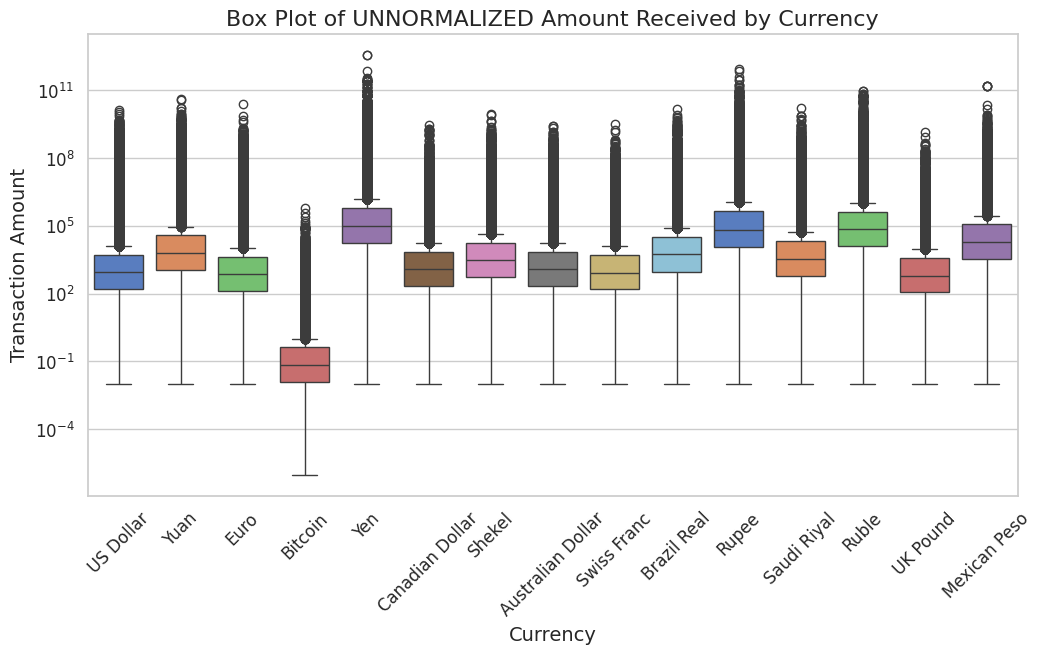

In [95]:
plt.figure(figsize=(12, 6))

# Store currencies for x-axis labels
currencies_to_plot = list(currencies)

# Create a list to store all amounts and corresponding currency labels
all_amounts = []
all_labels = []

for currency in currencies_to_plot:
    currency_transactions = data[data['Receiving Currency'] == currency]['Amount Received']
    all_amounts.extend(currency_transactions)
    all_labels.extend([currency] * len(currency_transactions))  # Assign currency labels

# Convert to DataFrame for seaborn
df_to_plot = pd.DataFrame({"Currency": all_labels, "Amount Received": all_amounts})

# Plot the boxplot with categorical x-axis
sns.boxplot(x="Currency", y="Amount Received", data=df_to_plot, palette=muted_palette)

# Labels and title
plt.xlabel("Currency")
plt.xticks(rotation=45)
plt.ylabel("Transaction Amount")
plt.title("Box Plot of UNNORMALIZED Amount RECEIVED by Currency")
plt.yscale("log")  # Log scale for better visualization

# Show plot
plt.show()

del currency_transactions, df_to_plot, all_amounts, all_labels

In [97]:
data.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,...,type_fraud,fraud_id,pattern_number,depth_info,depht_type_info,Date,forex_multiple_Amount Paid,Normaized_Amount Paid,forex_multiple_Amount Received,Normaized_Amount Received
0,2022-09-01,1807,801321C30,1807,801321C30,220579.84,US Dollar,220579.84,US Dollar,Reinvestment,...,NaN,NaN,NaN,NaN,NaN,2022-09-01,1.000000,220579.840000,1.000000,220579.840000
1,2022-09-01,16679,80B2E1890,217798,80BDED1B0,3067.32,US Dollar,3067.32,US Dollar,Credit Card,...,NaN,NaN,NaN,NaN,NaN,2022-09-01,1.000000,3067.320000,1.000000,3067.320000
2,2022-09-01,213504,80A0867A0,213504,80A0867A0,437443.44,Yuan,437443.44,Yuan,Reinvestment,...,NaN,NaN,NaN,NaN,NaN,2022-09-01,0.145161,63499.754525,0.145161,63499.754525
3,2022-09-01,319147,818B0F480,319147,818B0F480,14877.50,Euro,14877.50,Euro,Reinvestment,...,NaN,NaN,NaN,NaN,NaN,2022-09-01,1.003905,14935.599273,1.003905,14935.599273
4,2022-09-01,111913,809E0ABE0,111913,809E0ABE0,15.85,US Dollar,15.85,US Dollar,Reinvestment,...,NaN,NaN,NaN,NaN,NaN,2022-09-01,1.000000,15.850000,1.000000,15.850000


<ipython-input-98-f77a3a07fa2c>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Currency", y="Normaized_Amount Received", data=df_to_plot, palette='viridis')


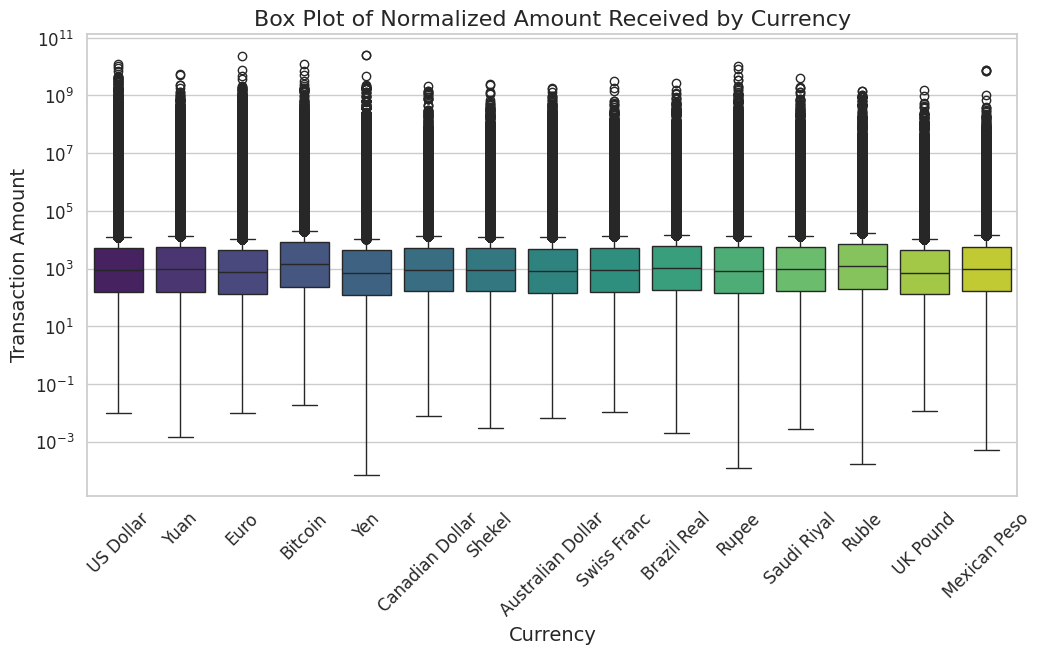

In [98]:
plt.figure(figsize=(12, 6))

# Store currencies for x-axis labels
currencies_to_plot = list(currencies)

# Create a list to store all amounts and corresponding currency labels
all_amounts = []
all_labels = []

for currency in currencies_to_plot:
    currency_transactions = data[data['Receiving Currency'] == currency]['Normaized_Amount Received']
    all_amounts.extend(currency_transactions)
    all_labels.extend([currency] * len(currency_transactions))  # Assign currency labels

# Convert to DataFrame for seaborn
df_to_plot = pd.DataFrame({"Currency": all_labels, "Normaized_Amount Received": all_amounts})

# Plot the boxplot with categorical x-axis
sns.boxplot(x="Currency", y="Normaized_Amount Received", data=df_to_plot, palette='viridis')

# Labels and title
plt.xlabel("Currency")
plt.xticks(rotation=45)
plt.ylabel("Transaction Amount")
plt.title("Box Plot of Normalized Amount RECEIVED by Currency")
plt.yscale("log")  # Log scale for better visualization

# Show plot
plt.show()

del currency_transactions, df_to_plot, all_amounts, all_labels

#### Sending

<ipython-input-101-cc1359bdcd8f>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Currency", y="Amount Paid", data=df_to_plot, palette=muted_palette)
<ipython-input-101-cc1359bdcd8f>:19: UserWarning: 
The palette list has fewer values (10) than needed (15) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x="Currency", y="Amount Paid", data=df_to_plot, palette=muted_palette)


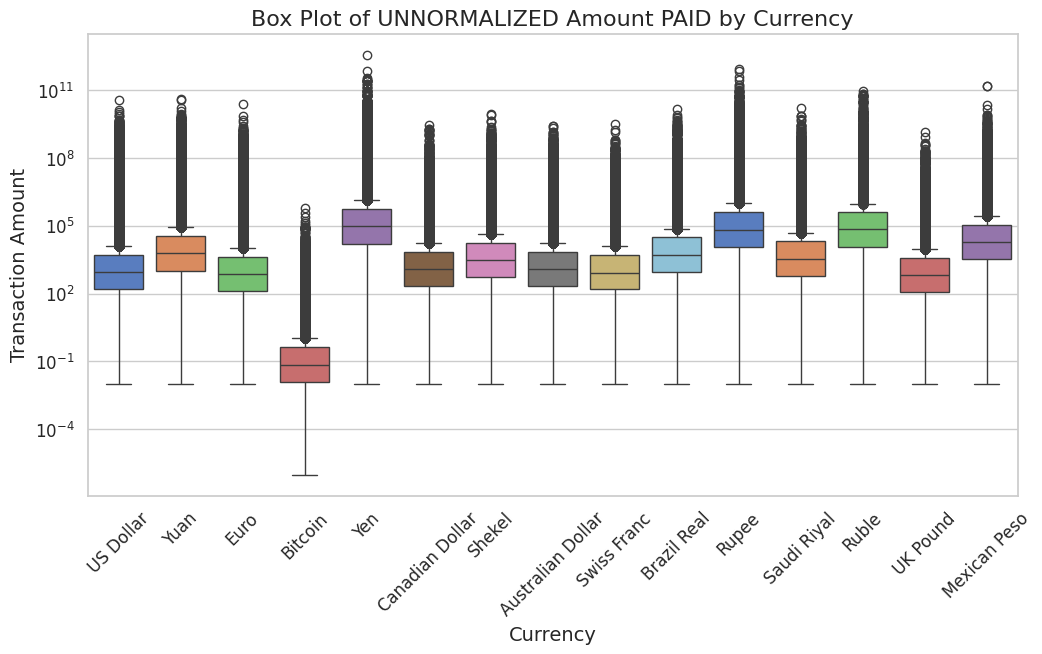

In [101]:
plt.figure(figsize=(12, 6))

# Store currencies for x-axis labels
currencies_to_plot = list(currencies)

# Create a list to store all amounts and corresponding currency labels
all_amounts = []
all_labels = []

for currency in currencies_to_plot:
    currency_transactions = data[data['Payment Currency'] == currency]['Amount Paid']
    all_amounts.extend(currency_transactions)
    all_labels.extend([currency] * len(currency_transactions))  # Assign currency labels

# Convert to DataFrame for seaborn
df_to_plot = pd.DataFrame({"Currency": all_labels, "Amount Paid": all_amounts})

# Plot the boxplot with categorical x-axis
sns.boxplot(x="Currency", y="Amount Paid", data=df_to_plot, palette=muted_palette)

# Labels and title
plt.xlabel("Currency")
plt.xticks(rotation=45)
plt.ylabel("Transaction Amount")
plt.title("Box Plot of UNNORMALIZED Amount PAID by Currency")
plt.yscale("log")  # Log scale for better visualization

# Show plot
plt.show()

del currency_transactions, df_to_plot, all_amounts, all_labels

In [100]:
data.columns

Index(['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1',
       'Amount Received', 'Receiving Currency', 'Amount Paid',
       'Payment Currency', 'Payment Format', 'Is Laundering', 'type_fraud',
       'fraud_id', 'pattern_number', 'depth_info', 'depht_type_info', 'Date',
       'forex_multiple_Amount Paid', 'Normaized_Amount Paid',
       'forex_multiple_Amount Received', 'Normaized_Amount Received'],
      dtype='object')

<ipython-input-102-195fb10ede25>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Currency", y="Normaized_Amount Paid", data=df_to_plot, palette='viridis')


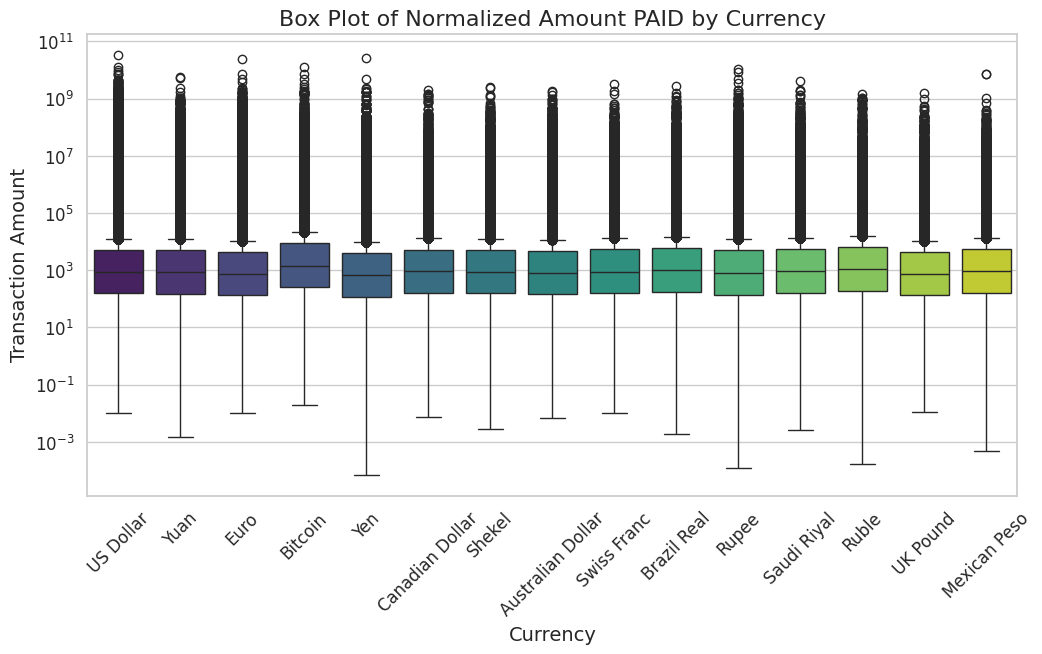

In [102]:
plt.figure(figsize=(12, 6))

# Store currencies for x-axis labels
currencies_to_plot = list(currencies)

# Create a list to store all amounts and corresponding currency labels
all_amounts = []
all_labels = []

for currency in currencies_to_plot:
    currency_transactions = data[data['Payment Currency'] == currency]['Normaized_Amount Paid']
    all_amounts.extend(currency_transactions)
    all_labels.extend([currency] * len(currency_transactions))  # Assign currency labels

# Convert to DataFrame for seaborn
df_to_plot = pd.DataFrame({"Currency": all_labels, "Normaized_Amount Paid": all_amounts})

# Plot the boxplot with categorical x-axis
sns.boxplot(x="Currency", y="Normaized_Amount Paid", data=df_to_plot, palette='viridis')

# Labels and title
plt.xlabel("Currency")
plt.xticks(rotation=45)
plt.ylabel("Transaction Amount")
plt.title("Box Plot of Normalized Amount PAID by Currency")
plt.yscale("log")  # Log scale for better visualization

# Show plot
plt.show()

del currency_transactions, df_to_plot, all_amounts, all_labels

### High Caliber Transactions

In [152]:
normalized_amount_df = pd.melt(data, value_vars = ['Normaized_Amount Paid', 'Normaized_Amount Received'],
                               value_name = 'Normalized Amount', id_vars = ['Is Laundering'])

In [153]:
normalized_amount_df['Normalized Amount'].describe()

,Normalized Amount
count,1.384810e+07
mean,3.450994e+05
std,2.517700e+07
min,7.178957e-05
25%,1.522109e+02
50%,8.604686e+02
75%,5.089360e+03
max,3.458115e+10


In [171]:
quantiles_list = [0.75, 0.8, 0.85, 0.9, 0.92, 0.94, 0.95, 0.97, 0.98,0.99, 0.995, 0.9975, 0.99995]
quantiles = normalized_amount_df["Normalized Amount"].quantile(quantiles_list)
quantiles = quantiles.to_frame()
true_quantiles = [((1-i)) for i in quantiles.index]

# total_quantiles = [
#   0.005, 0.01, 0.02, 0.03, 0.05, 0.06, 0.08, 0.1,
#   0.15, 0.2, 0.25, 0.75, 0.8, 0.85, 0.9, 0.92,
#   0.94, 0.95, 0.97, 0.98, 0.99, 0.995, , 0.9975, 0.9999
# ]

quantiles.index = true_quantiles

In [160]:
# diffs = [(0.75 - (i - 0.75)) for i in quantiles_list[1:]]
# print(diffs)

# left_tail = list(reversed(diffs))

# total_quantiles = left_tail + quantiles_list

# # true_total_quantiles = [((1-i) * 2) for i in total_quantiles]
# # true_total_quantiles


[0.7, 0.65, 0.6, 0.58, 0.56, 0.55, 0.53, 0.52, 0.51, 0.505, 0.5025, 0.50005]


In [165]:
quantiles.columns

Index(['Normalized Amount'], dtype='object')

In [172]:
values = []
for quantile, quantile_value in zip(quantiles.index, quantiles['Normalized Amount'].values):

  greater_than = normalized_amount_df[normalized_amount_df['Normalized Amount'] >= quantile_value]

  print(f'The percentage is: {(len(greater_than) / len(normalized_amount_df))}')

  frauds = greater_than['Is Laundering'].sum()

  values.append(frauds)

# del greater_than
values = [i/2 for i in values]
# quantiles.loc[:,'Number of frauds'] = values

The percentage is: 0.2500004693785385
The percentage is: 0.20000002888483315
The percentage is: 0.1500000938757077
The percentage is: 0.10000008665449941
The percentage is: 0.0800000837660161
The percentage is: 0.06000015308961563
The percentage is: 0.05000000722120829
The percentage is: 0.030000509817304875
The percentage is: 0.02000007510056616
The percentage is: 0.0100000736563245
The percentage is: 0.005000109040245094
The percentage is: 0.00250012673220539
The percentage is: 5.011518549334356e-05


In [173]:
# quantiles = quantiles.to_frame()
quantiles['N_Frauds'] = values
quantiles.index.name = 'Survival Quantile'
quantiles.columns = ['Normalized Amount', 'Number of frauds']
quantiles['Number of frauds'] = quantiles['Number of frauds'].astype(int)

total_frauds = normalized_amount_df['Is Laundering'].sum()
print(total_frauds)

quantiles['Percentage of Frauds'] = quantiles['Number of frauds'] / total_frauds

quantiles

7130


,Normalized Amount,Number of frauds,Percentage of Frauds
Survival Quantile,,,
0.25000,5.089360e+03,1208,0.169425
0.20000,8.572657e+03,839,0.117672
0.15000,1.567641e+04,411,0.057644
0.10000,3.441195e+04,172,0.024123
0.08000,6.118752e+04,125,0.017532
0.06000,1.221021e+05,103,0.014446
0.05000,1.820486e+05,99,0.013885
0.03000,4.915244e+05,78,0.010940
0.02000,9.583182e+05,62,0.008696


In [169]:
quantiles['Number of frauds'].sum()

np.int64(3216)

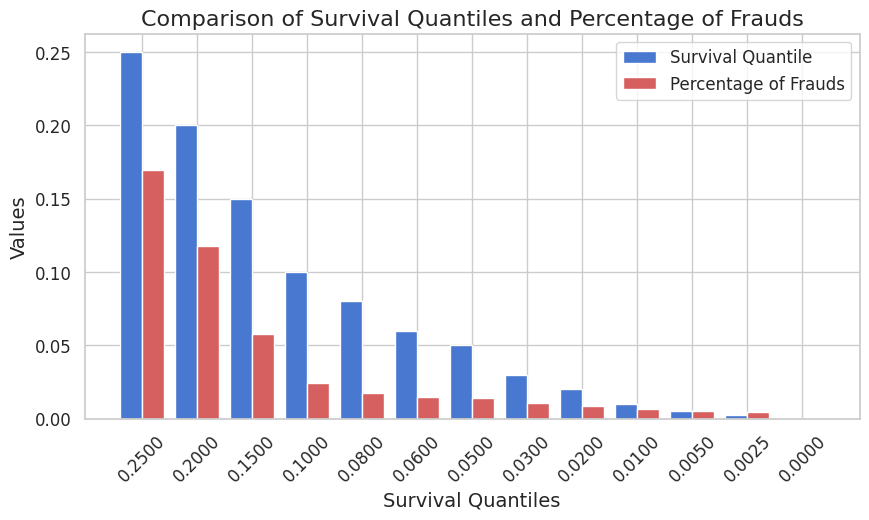

In [174]:
# Convert index to float values for plotting
quantile_values = quantiles.index.astype(float)
fraud_percentages = quantiles["Percentage of Frauds"]

# Set bar width
bar_width = 0.4

# Define positions for the bars
x_indexes = np.arange(len(quantile_values))

# Create the bar plot
plt.figure(figsize=(10, 5))
plt.bar(x_indexes - bar_width/2, quantile_values, width=bar_width, label="Survival Quantile", color = blueish_color)
plt.bar(x_indexes + bar_width/2, fraud_percentages, width=bar_width, label="Percentage of Frauds", color = reddish_color)

# Labels and title
plt.xlabel("Survival Quantiles")
plt.ylabel("Values")
plt.title("Comparison of Survival Quantiles and Percentage of Frauds")
# Format x-ticks to show fewer decimals
formatted_labels = [f"{x:.4f}" for x in quantile_values]  # Keep 3 decimal places

# Apply formatted labels to x-axis
plt.xticks(ticks=x_indexes, labels=formatted_labels, rotation=45)
plt.legend()

# Show plot
plt.show()

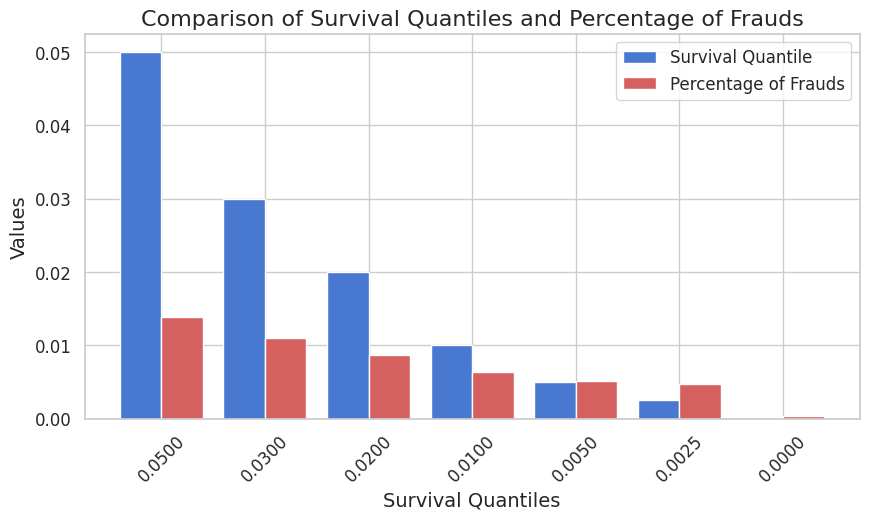

In [175]:
# Convert index to float values for plotting
quantile_values = quantiles.index.astype(float)[6:]
fraud_percentages = quantiles["Percentage of Frauds"].iloc[6:]

# Set bar width
bar_width = 0.4

# Define positions for the bars
x_indexes = np.arange(len(quantile_values))

# Create the bar plot
plt.figure(figsize=(10, 5))
plt.bar(x_indexes - bar_width/2, quantile_values, width=bar_width, label="Survival Quantile", color = blueish_color)
plt.bar(x_indexes + bar_width/2, fraud_percentages, width=bar_width, label="Percentage of Frauds", color = reddish_color)

# Labels and title
plt.xlabel("Survival Quantiles")
plt.ylabel("Values")
plt.title("Comparison of Survival Quantiles and Percentage of Frauds")
# Format x-ticks to show fewer decimals
formatted_labels = [f"{x:.4f}" for x in quantile_values]  # Keep 3 decimal places

# Apply formatted labels to x-axis
plt.xticks(ticks=x_indexes, labels=formatted_labels, rotation=45)
plt.legend()

# Show plot
plt.show()

In [178]:
diffs = [(0.75 - (i - 0.75)) for i in quantiles_list[1:]]
print(diffs)

left_tail = list(reversed(diffs))

total_quantiles = left_tail + quantiles_list

true_total_quantiles = [((1-i)) for i in total_quantiles]


[0.7, 0.65, 0.6, 0.58, 0.56, 0.55, 0.53, 0.52, 0.51, 0.505, 0.5025, 0.50005]


In [177]:
quantiles = normalized_amount_df["Normalized Amount"].quantile(total_quantiles)

quantiles.index = true_total_quantiles

In [ ]:
normalized_amount_df["Normalized Amount"].min()

In [ ]:
values = []
for quantile, quantile_value in zip(quantiles.index, quantiles["Normalized Amount"].values):

  greater_than = normalized_amount_df[normalized_amount_df['Normalized Amount'] >= quantile_value]

  print(f'The percentage is: {(len(greater_than) / len(normalized_amount_df))}')

  frauds = greater_than['Is Laundering'].sum()

  values.append(frauds)

# del greater_than
values = [i/2 for i in values]
# quantiles.loc[:,'Number of frauds'] = values

In [ ]:
quantiles = quantiles.to_frame()
quantiles['N_Frauds'] = values
quantiles.index.name = 'Survival Quantile'
quantiles.columns = ['Normalized Amount', 'Number of frauds']
quantiles['Number of frauds'] = quantiles['Number of frauds'].astype(int)

total_frauds = len(data[data['Is Laundering'] == 1])
print(total_frauds)

quantiles['Percentage of Frauds'] = quantiles['Number of frauds'] / total_frauds

quantiles

# Account Graph Analysis

## Creating the Graph

#### Single-Edge Graph

The following will create a graph in which the edge between two accounts will be a unique one, no matter the amount of activity that happens between them.

In [ ]:
data.dtypes

,0
Timestamp,datetime64[ns]
From Bank,int64
Account,object
To Bank,int64
Account.1,object
Amount Received,float64
Receiving Currency,object
Amount Paid,float64
Payment Currency,object
Payment Format,object


In [ ]:
st = time.time()
# Create an undirected graph from your DataFrame
account_graph = nx.from_pandas_edgelist(data, source='Account', target='Account.1')

# Compute connectivity: the number of unique neighbors (interactions) for each account
connectivity = dict(account_graph.degree())

connectivity_df = pd.DataFrame(list(connectivity.items()), columns=['Accounts', 'Connectivity'])

et = time.time()

print(f'Total time is: {et - st:.2f}')

Total time is: 35.69


#### Multi-Edge Graph

In this case, instead, we create a dataset in which each transaction between two accounts is represented by a dedicated edge.

In [ ]:
# multi_account_graph = nx.from_pandas_edgelist(
#     data,
#     source='Account',
#     target='Account.1',
#     edge_attr='Is Laundering',
#     create_using=nx.MultiGraph()
# )


In [ ]:
# Assuming account_graph is a MultiGraph
# unique_connectivity = {node: len(multi_account_graph[node]) for node in multi_account_graph.nodes()}

# # If you want to convert the result to a DataFrame:
# import pandas as pd
# connectivity_df = pd.DataFrame(list(unique_connectivity.items()), columns=['Accounts', 'Connectivity'])

# et = time.time()

# print(f'Total time is: {et - st:.2f}')

Check

## Account/Node Emergence

The purpose of this analysis is to assess if there is an evolution over time of the number of accounts (i.e. the nodes in our graph) in terms of their number. In particular, we want to assess if and how many new accounts enter the graph on a daily basis.

In [ ]:
data['Date'] = data['Timestamp'].dt.floor('D')

# Specify the cutoff day (here, 2022-09-10 is known to be incomplete)
cutoff_day = pd.to_datetime('2022-09-10')

# Filter to only include records before the cutoff day
data = data[data['Date'] < cutoff_day]

# Making sure the dates are sorted
dates = data['Date'].unique()


sorted_dates = np.sort(dates)

sorted_dt_array = pd.array(sorted_dates)

# print('\n')
# print(sorted_dt_array)
# print(type(sorted_dt_array))
# print(f'The type of the first entry is: {type(sorted_dt_array[0])}')

We will now proceed to assess the number of different accounts that were active on a given day and how many of them are new with respect to the day before

In [ ]:
new_accounts_number_df = pd.DataFrame(index = sorted_dt_array, columns = ['Daily Active Accounts', 'New Accounts', 'Daily Transactions'])

tot_accounts_set = set()

In [ ]:
for date in sorted_dt_array:

  values = []
  print('\n')
  print('*'*100)
  print(date)
  daily_melted_transactions = data[data['Date'] == date].melt(value_vars=['Account', 'Account.1'],
                                  var_name='Account_Type',
                                  value_name='Accounts',
                                  id_vars = 'Date')

  #This is the number of the transactions on the day
  print(f'The number of transactions this day is: {len(daily_melted_transactions)}')

  #This retrieves a np.ndarray with all the accounts that were active during the day
  daily_active_accounts = daily_melted_transactions['Accounts'].unique()

  print(f'The daily active accounts are: {len(daily_active_accounts)}')

  values.append(len(daily_active_accounts))

  #This transforms it into a set
  daily_active_accounts = set(daily_active_accounts)

  #The new set of accounts will be the union of that of the day
  #before with the set of accounts that were active today
  new_tot_accounts_set = tot_accounts_set.union(daily_active_accounts)

  #The number of new accounts that were not previously active
  new_accounts_count = len(new_tot_accounts_set) - len(tot_accounts_set)

  print(f'The new accounts are: {new_accounts_count}')

  values.append(new_accounts_count)

  #We update the set of accounts that did at least one transaction before
  tot_accounts_set = new_tot_accounts_set

  values.append(len(daily_melted_transactions))

  new_accounts_number_df.loc[date, :] = values


del daily_melted_transactions



****************************************************************************************************
2022-09-01 00:00:00
The number of transactions this day is: 3049614
The daily active accounts are: 599154
The new accounts are: 599154


****************************************************************************************************
2022-09-02 00:00:00
The number of transactions this day is: 2055516
The daily active accounts are: 483160
The new accounts are: 99768


****************************************************************************************************
2022-09-03 00:00:00
The number of transactions this day is: 566652
The daily active accounts are: 201707
The new accounts are: 1188


****************************************************************************************************
2022-09-04 00:00:00
The number of transactions this day is: 564952
The daily active accounts are: 200575
The new accounts are: 993


******************************************************

In [ ]:
#Total Number of accounts
new_accounts_number_df['Total Accounts'] = np.cumsum(new_accounts_number_df.loc[:,'New Accounts'])

#Rearranging the columns for better visualization
new_order = ['Total Accounts', 'Daily Transactions', 'Daily Active Accounts', 'New Accounts']
new_accounts_number_df = new_accounts_number_df[new_order]

new_accounts_number_df = new_accounts_number_df.copy()

#Normalizing the number of new accounts by the number of daily transactions
new_accounts_number_df['New Accounts per Transaction'] = (new_accounts_number_df['New Accounts'] / new_accounts_number_df['Daily Transactions']) * 100

#Normalizing the number of new accounts by the number of accounts that were active
#on the given day.
new_accounts_number_df['New Accounts per Daily Active Accounts'] = (new_accounts_number_df['New Accounts'] / new_accounts_number_df['Daily Active Accounts']) * 100


#Assessing the percentage increase in the number of accounts compared to the
#day before.
new_accounts_number_df['% Increase from previous day'] = (new_accounts_number_df['New Accounts'] / new_accounts_number_df['Total Accounts'].shift(1)) * 100

#Percentage increase in the number of accounts compared to the first day
new_accounts_number_df['% Increase from 1st day'] = (new_accounts_number_df['New Accounts'] / new_accounts_number_df['New Accounts'].iloc[0]) * 100



In [ ]:
new_accounts_number_df

Check

In [ ]:
melted_df = data.melt(value_vars=['Account', 'Account.1'],
                                  var_name='Account_Type',
                                  value_name='Accounts')


account_number_check  = len(melted_df['Accounts'].unique())

our_number_accounts = new_accounts_number_df['Total Accounts'].iloc[-1]

if account_number_check != our_number_accounts:

  raise UserWarning('The number of accounts is incorrect')

del melted_df

### Analyzing Account Emergence

Total Accounts Increase

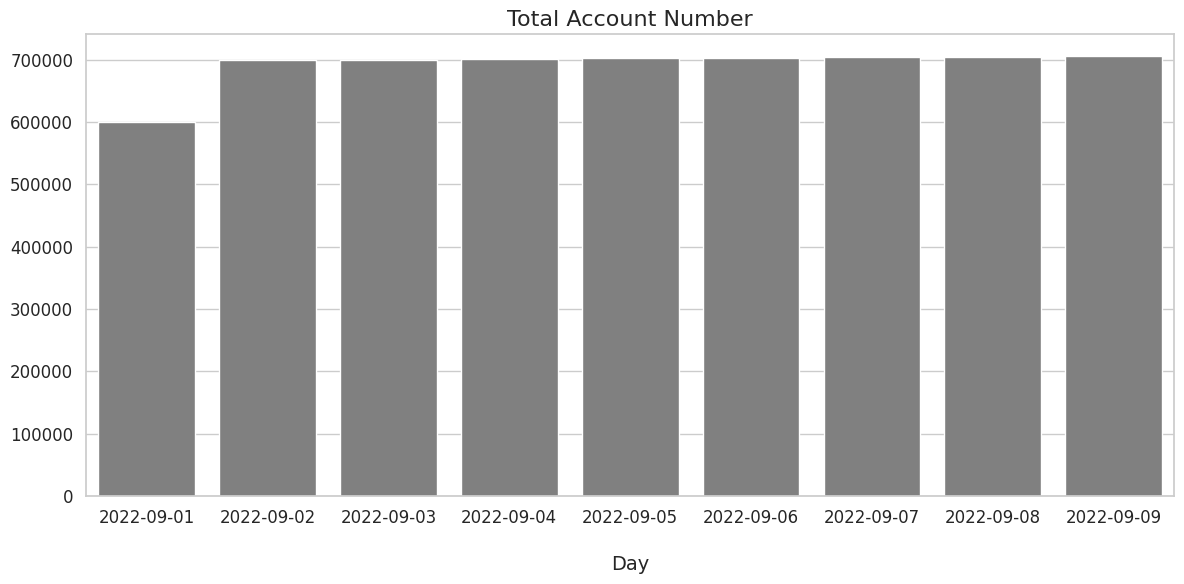

In [ ]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

#sns.set(style='whitegrid')

# Plot bar chart
sns.barplot(
    x=new_accounts_number_df.index,
    y=new_accounts_number_df['Total Accounts'].values,
    color= 'Grey'  # Use a single color from muted_palette
)

# Set y-axis ticks to integers
#ax.set_yticks(np.arange(0, new_accounts_number_df[avenue].iloc[1:].max() + 1, 1))

# Labels and title
ax.set_title('Total Account Number')
ax.set_xlabel('Day', labelpad=20)
#ax.set_ylabel('Count')
plt.xticks(rotation=0)

# Show plot
plt.tight_layout()
plt.show()

Account increase

In [ ]:
avenues_analysis = ['New Accounts', 'New Accounts per Daily Active Accounts','New Accounts per Transaction','% Increase from previous day', '% Increase from 1st day', ]

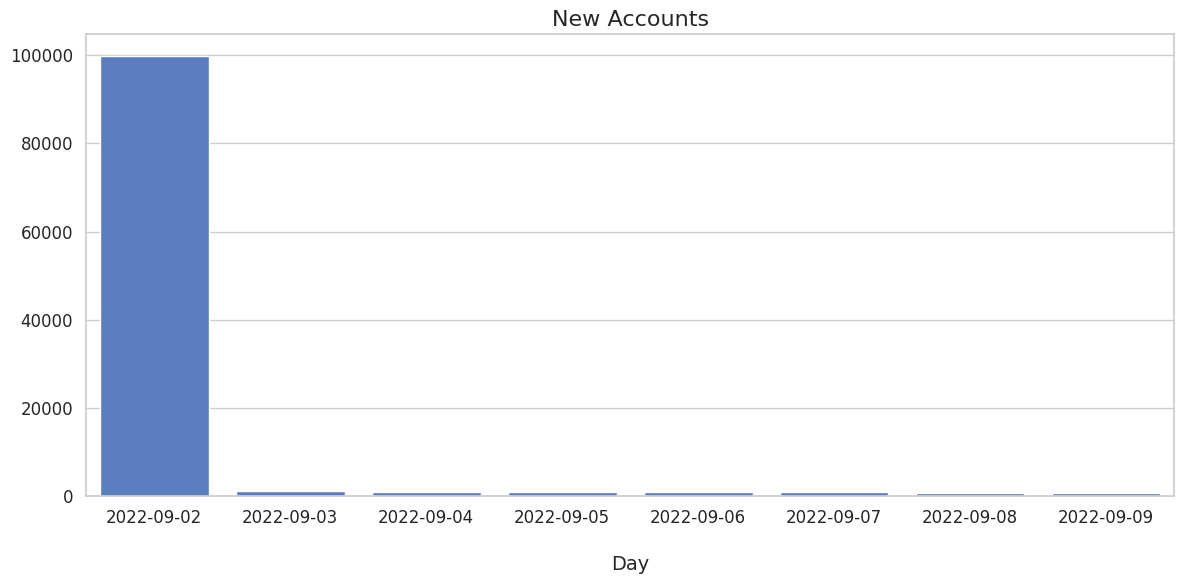

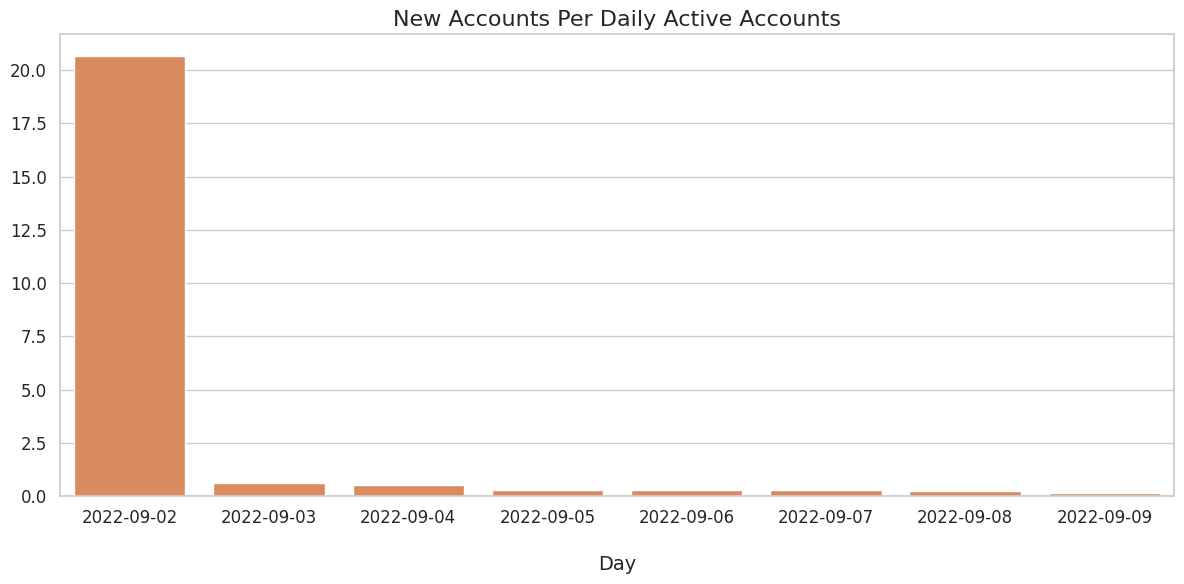

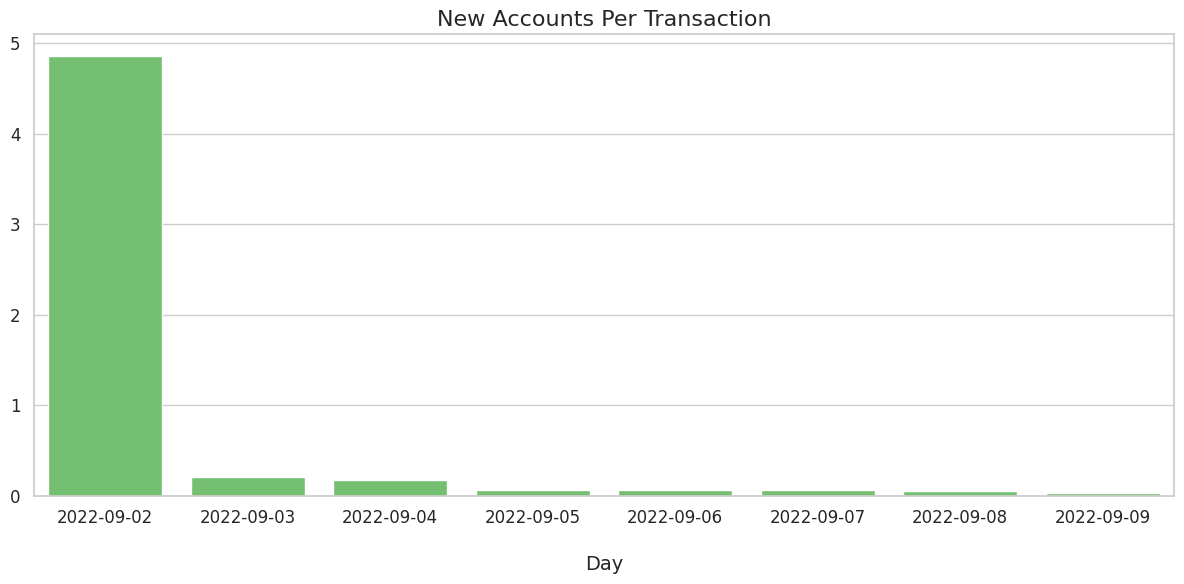

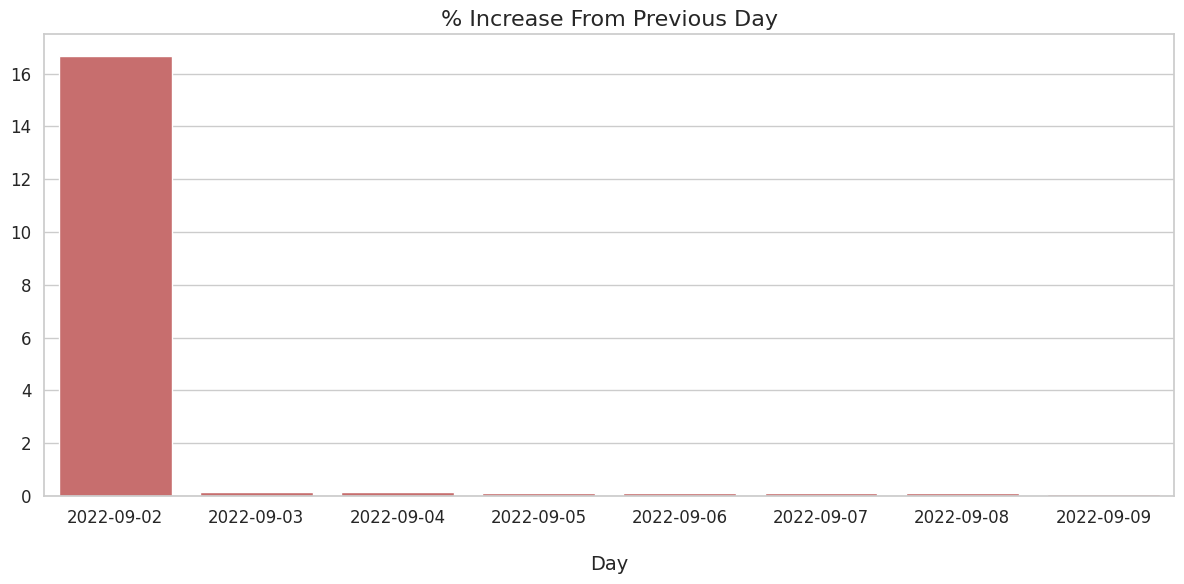

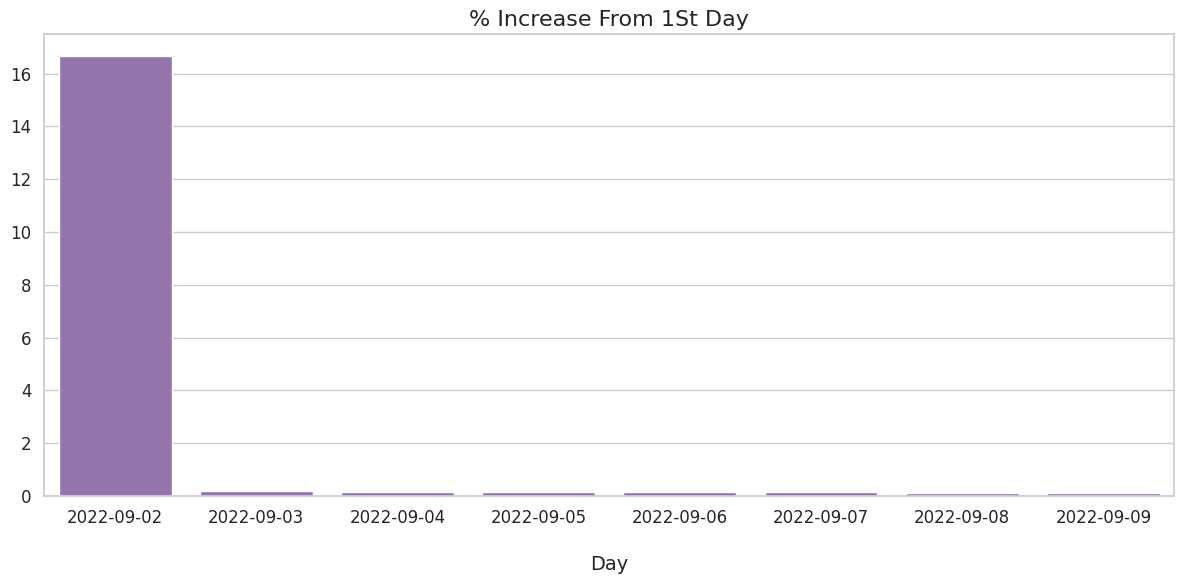

In [ ]:
for idx, avenue in enumerate(avenues_analysis):

  # Create figure and axis
  fig, ax = plt.subplots(figsize=(12, 6))

  #sns.set(style='whitegrid')

  # Plot bar chart
  sns.barplot(
      x=new_accounts_number_df.iloc[1:].index,
      y=new_accounts_number_df[avenue].iloc[1:].values,
      color=muted_palette[idx]  # Use a single color from muted_palette
  )

  # Set y-axis ticks to integers
  #ax.set_yticks(np.arange(0, new_accounts_number_df[avenue].iloc[1:].max() + 1, 1))

  # Labels and title
  ax.set_title(avenue.title())
  ax.set_xlabel('Day', labelpad=20)
  #ax.set_ylabel('Count')
  plt.xticks(rotation=0)

  # Show plot
  plt.tight_layout()
  plt.show()

Excluding the second day

In [ ]:
for idx, avenue in enumerate(avenues_analysis):

  # Create figure and axis
  fig, ax = plt.subplots(figsize=(12, 6))

  #sns.set(style='whitegrid')

  # Plot bar chart
  sns.barplot(
      x=new_accounts_number_df.iloc[2:].index,
      y=new_accounts_number_df[avenue].iloc[2:].values,
      color=muted_palette[idx]  # Use a single color from muted_palette
  )


  # Labels and title
  ax.set_title(avenue.title() + '- Excluding the second day')
  ax.set_xlabel('Day', labelpad=20)

  plt.xticks(rotation=0)

  # Show plot
  plt.tight_layout()
  plt.show()

## Edge Emergence

In [ ]:
edge_df = pd.DataFrame(index = sorted_dt_array, columns = ['Total Edges'])

In [ ]:
for day in sorted_dt_array:


  print(day)
  st = time.time()

  up_until_data = data[data['Date'] <= day]
  # Create an undirected graph from your DataFrame
  G = nx.from_pandas_edgelist(up_until_data, source='Account', target='Account.1')

  total_edges = G.number_of_edges()
  print(f"Total number of edges: {total_edges}")

  edge_df.loc[day, 'Total Edges'] = total_edges

  et = time.time()
  print(f'Time elapsed: {et - st}')
# # Compute connectivity: the number of unique neighbors (interactions) for each account
# connectivity = dict(account_graph.degree())

# connectivity_df = pd.DataFrame(list(connectivity.items()), columns=['Accounts', 'Connectivity'])

# et = time.time()

# print(f'Total time is: {et - st:.2f}')

del G


2022-09-01 00:00:00
Total number of edges: 926171
Time elapsed: 7.265445232391357
2022-09-02 00:00:00
Total number of edges: 1173862
Time elapsed: 12.420203924179077
2022-09-03 00:00:00
Total number of edges: 1204040
Time elapsed: 13.357394456863403
2022-09-04 00:00:00
Total number of edges: 1231528
Time elapsed: 22.601468324661255
2022-09-05 00:00:00
Total number of edges: 1258172
Time elapsed: 19.080352306365967
2022-09-06 00:00:00
Total number of edges: 1283701
Time elapsed: 24.827649354934692
2022-09-07 00:00:00
Total number of edges: 1309273
Time elapsed: 23.916162729263306
2022-09-08 00:00:00
Total number of edges: 1333750
Time elapsed: 28.62300205230713
2022-09-09 00:00:00
Total number of edges: 1356965
Time elapsed: 48.51840925216675


In [ ]:
total_edges_final = account_graph.number_of_edges()
edge_df['Percentage of Final Day'] = (edge_df['Total Edges'] / total_edges_final) * 100

edge_df['Percentage Increase'] =  ((edge_df['Total Edges'] / edge_df['Total Edges'].shift(1))-1) * 100

edge_df['Absolute Increase'] = edge_df['Total Edges'] - edge_df['Total Edges'].shift(1)

In [ ]:
edge_df

,Total Edges,Percentage of Final Day,Percentage Increase,Absolute Increase
2022-09-01,926171,68.253124,NaN,NaN
2022-09-02,1173862,86.506432,26.74355,247691
2022-09-03,1204040,88.730365,2.57083,30178
2022-09-04,1231528,90.756062,2.282981,27488
2022-09-05,1258172,92.719562,2.163491,26644
2022-09-06,1283701,94.600892,2.029055,25529
2022-09-07,1309273,96.485392,1.992053,25572
2022-09-08,1333750,98.289197,1.869511,24477
2022-09-09,1356965,100.0,1.740581,23215


### Analyzing Edge Emergence

## Accounts Transaction Activity

In [ ]:
data = df_augmented

del df_augmented
#This will obtain the subset of transactions marked as fraudulent
fraudulent_transactions = data.loc[data['Is Laundering'] == 1, :]

#This will obtain the subset of transactions marked as legitimate
non_fraudulent_transactions = data.loc[data['Is Laundering'] == 0, :]

print(fraudulent_transactions._is_view)

fraudulent_accounts = accounts_type(fraudulent_transactions, category = 'Fraudulent')

non_fraudulent_accounts = accounts_type(non_fraudulent_transactions, category = 'Legitimate')

legitimate_accounts = non_fraudulent_accounts - fraudulent_accounts

False
****************************************************************************************************
FRAUDULENT ACCOUNTS

The number of Fraudulent SENDING df accounts is: 2382

The number of Fraudulent RECEIVING accounts is: 3304

The number of Fraudulent accounts involved on BOTH SIDES of df transactions is: 382
****************************************************************************************************
LEGITIMATE ACCOUNTS

The number of Legitimate SENDING df accounts is: 681162

The number of Legitimate RECEIVING accounts is: 576136

The number of Legitimate accounts involved on BOTH SIDES of df transactions is: 551441


In [ ]:
#This returns a Dataframe with the number of transactions for each account
accounts_activity = data.melt(value_vars = ['Account', 'Account.1'], value_name= 'Accounts').groupby('Accounts').size().reset_index(name='Transactions')

In [ ]:
print(f'The number of different accounts is: {accounts_activity.shape[0]}')

The number of different accounts is: 705903


In [ ]:
accounts_activity.head()

,Accounts,Transactions
0,10042B660,223590
1,10042B6A8,139728
2,10042B6F0,42730
3,10042B738,18348
4,10042B780,31025


This not only creates a dataframe whereby we know, for each account, with how many different accounts did each account interact with, but we also obtain a graph object with nodes being the Accounts and the Edges being the transactions.

## **Analyzing the connectivity of the accounts**

---

In [ ]:
#We then merge the two dataframes in order to obtain a single object containing
#both the activity and the connectivity information of each account.
nodes_df = pd.merge(accounts_activity,
                     connectivity_df,
                     on="Accounts",
                     how="left")

#### Normalizing connectivity by number of transactions

In [ ]:
if not (len(nodes_df) == len(accounts_activity) == len(connectivity_df)):

  raise UserWarning('The Merge did not go according to plan')

print(f'The number of NaN by column is: \n{nodes_df.isna().sum()}')

The number of NaN by column is: 
Accounts        0
Transactions    0
Connectivity    0
dtype: int64


In [ ]:
#We attempt to create a "Normalized" connectivity measure by dividing
#it by the number of total transactions a given account was involved in.
nodes_df['Connectivity_Ratio'] = nodes_df['Connectivity'] / nodes_df['Transactions']

nodes_df = nodes_df.sort_values(by = 'Transactions', ascending = False)

In [ ]:
nodes_df.head()

,Accounts,Transactions,Connectivity,Connectivity_Ratio
0,10042B660,223590,19727,0.088228
1,10042B6A8,139728,12355,0.088422
2,10042B6F0,42730,3787,0.088626
4,10042B780,31025,2738,0.088251
14,10042BA51,29016,2516,0.086711


In [ ]:
if len(nodes_df) != len(accounts_activity):

  raise UserWarning('The Merge did not go according to plan')

#### Connectivity Ratio vs Number of Transactions

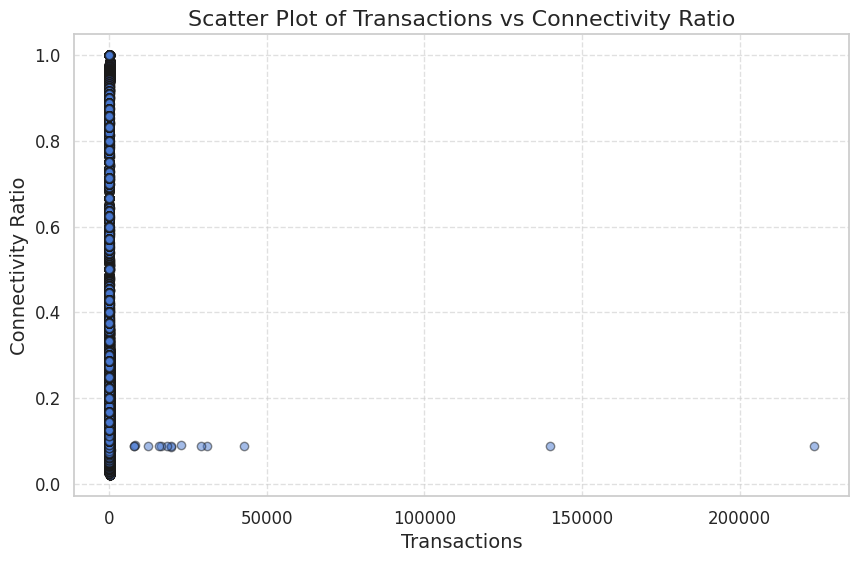

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(nodes_df['Transactions'], nodes_df['Connectivity_Ratio'],
            color=blueish_color, alpha=0.5, edgecolors='k')  # Change 'blue' to any color you like

# Labels and Title
plt.xlabel('Transactions')
plt.ylabel('Connectivity Ratio')
plt.title('Scatter Plot of Transactions vs Connectivity Ratio')

# Show Grid
plt.grid(True, linestyle='--', alpha=0.6)

# Display the plot
plt.show()

#### Removing the outliers

In [ ]:
remove_outliers_number = 15
cleaned_nodes_df = nodes_df.iloc[remove_outliers_number:, :]

outliers_df = nodes_df.iloc[:remove_outliers_number, :]

print(cleaned_nodes_df._is_view)

False


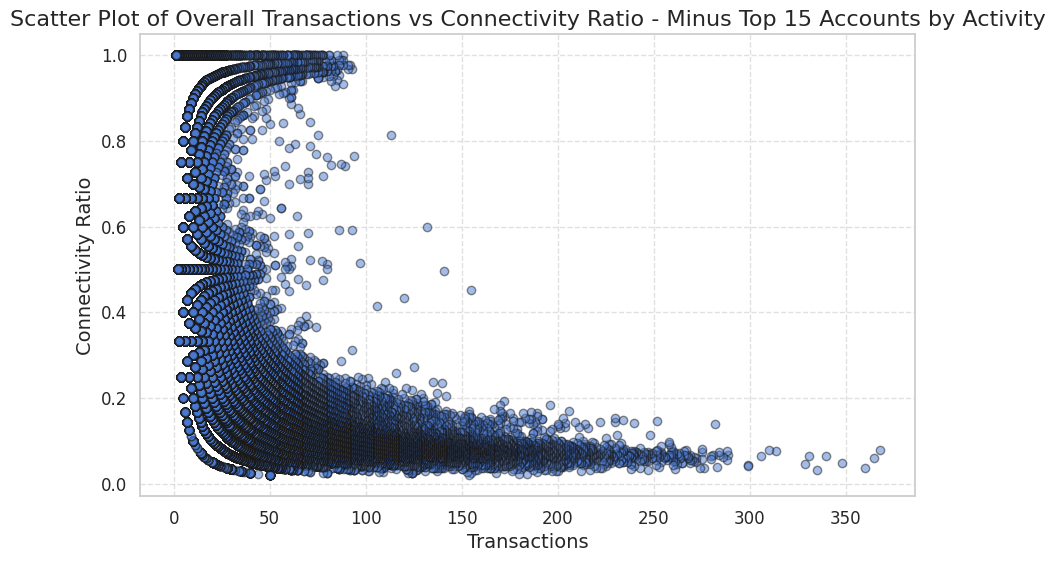

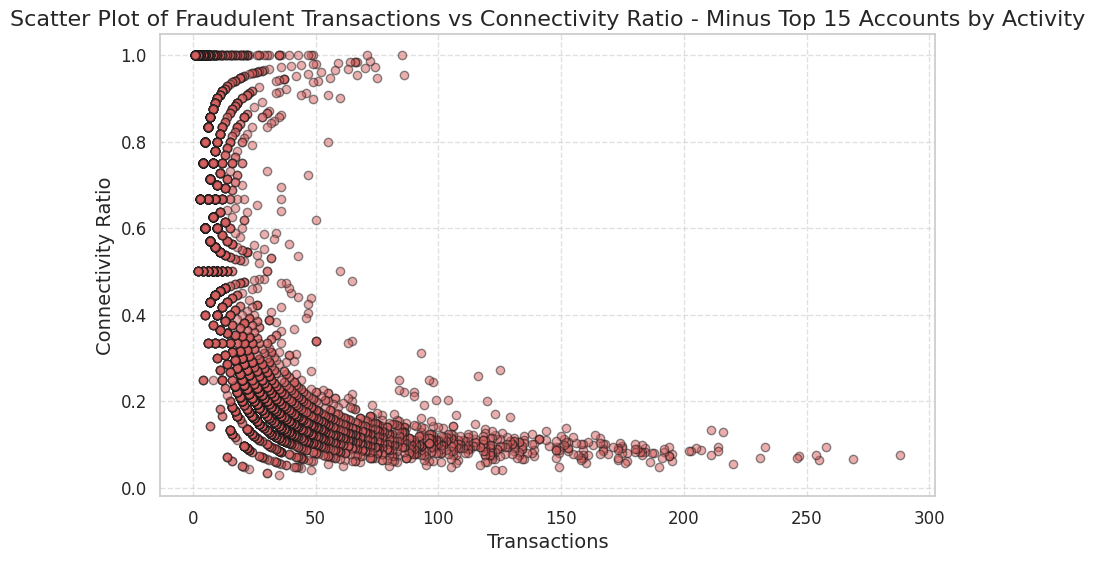

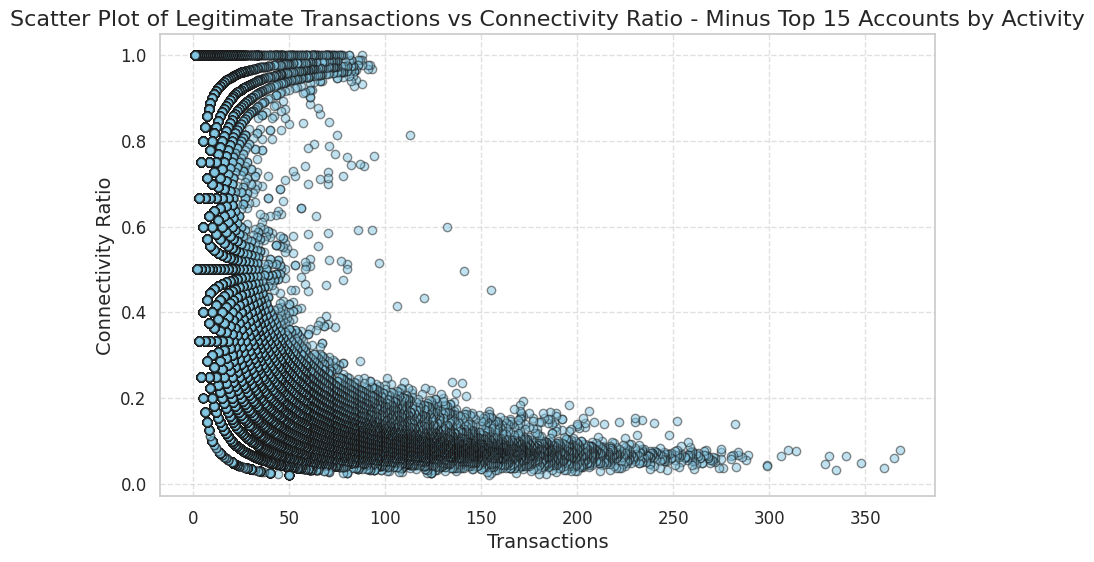

In [ ]:
scatter_transaction_connectivity_ratio(cleaned_nodes_df, title = 'Overall')

scatter_transaction_connectivity_ratio(cleaned_nodes_df[cleaned_nodes_df['Accounts'].isin(fraudulent_accounts)],
                                       title = 'Fraudulent', color = reddish_color)

scatter_transaction_connectivity_ratio(cleaned_nodes_df[~cleaned_nodes_df['Accounts'].isin(fraudulent_accounts)],
                                       title = 'Legitimate', color = muted_palette[9])

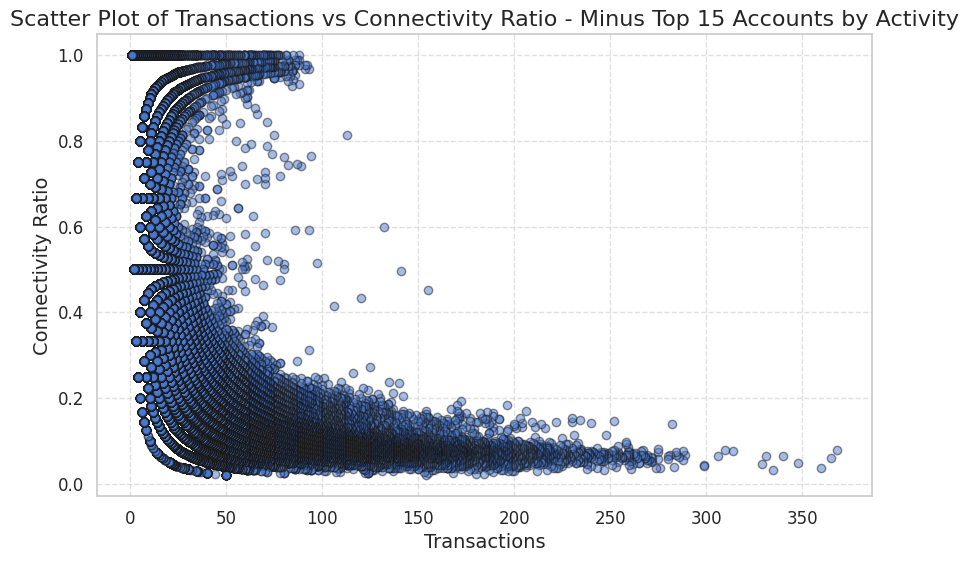

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(cleaned_nodes_df['Transactions'], cleaned_nodes_df['Connectivity_Ratio'],
            color=blueish_color, alpha=0.5, edgecolors='k')  # Change 'blue' to any color you like

# Labels and Title
plt.xlabel('Transactions')
plt.ylabel('Connectivity Ratio')
plt.title(f'Scatter Plot of Transactions vs Connectivity Ratio - Minus Top {remove_outliers_number} Accounts by Activity')

# Show Grid
plt.grid(True, linestyle='--', alpha=0.6)

# Display the plot
plt.show()

#### Overall Connectivity Comparison: Fraudulent vs Legitimate Accounts

In [ ]:
fraudulent_nodes_df = cleaned_nodes_df[cleaned_nodes_df['Accounts'].isin(fraudulent_accounts)]

legitimate_nodes_df = cleaned_nodes_df[~cleaned_nodes_df['Accounts'].isin(fraudulent_accounts)]

In [ ]:
print(fraudulent_nodes_df['Connectivity'].describe())
print('\n')
print(legitimate_nodes_df['Connectivity'].describe())

count    5289.000000
mean        6.777841
std         5.843489
min         1.000000
25%         4.000000
50%         5.000000
75%         8.000000
max        85.000000
Name: Connectivity, dtype: float64


count    700599.000000
mean          3.811036
std           3.119808
min           1.000000
25%           2.000000
50%           3.000000
75%           5.000000
max          92.000000
Name: Connectivity, dtype: float64


In [ ]:
legitimate_nodes_df = legitimate_nodes_df.sort_values(by = 'Connectivity')
fraudulent_nodes_df = fraudulent_nodes_df.sort_values(by = 'Connectivity')

<ipython-input-110-6e821e2d317a>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Type', y='Connectivity', data=combined_df, palette=palette)


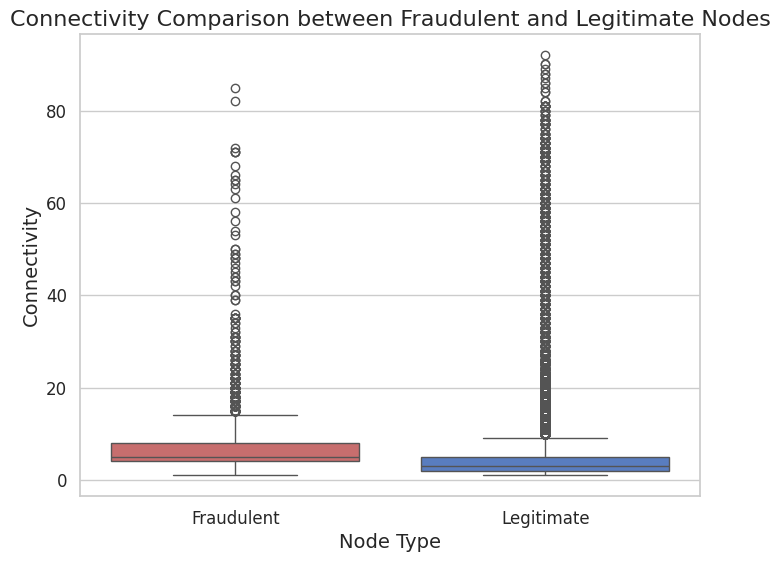

In [ ]:
# Create a lightweight combined DataFrame containing only the needed columns
combined_df = pd.concat([
    pd.DataFrame({'Connectivity': fraudulent_nodes_df['Connectivity'], 'Type': 'Fraudulent'}),
    pd.DataFrame({'Connectivity': legitimate_nodes_df['Connectivity'], 'Type': 'Legitimate'})
])

# Define a palette mapping for custom colors
palette = {
    'Fraudulent': reddish_color,  # e.g., (1.0, 0.2, 0.2) or any valid matplotlib color format
    'Legitimate': blueish_color     # e.g., (0.2, 0.4, 1.0)
}

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Connectivity', data=combined_df, palette=palette)
plt.title('Connectivity Comparison between Fraudulent and Legitimate Nodes')
plt.xlabel('Node Type')
plt.ylabel('Connectivity')
plt.show()

del combined_df

<ipython-input-111-37efd38b1100>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=fraudulent_nodes_df['Connectivity'],
<ipython-input-111-37efd38b1100>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=legitimate_nodes_df['Connectivity'],


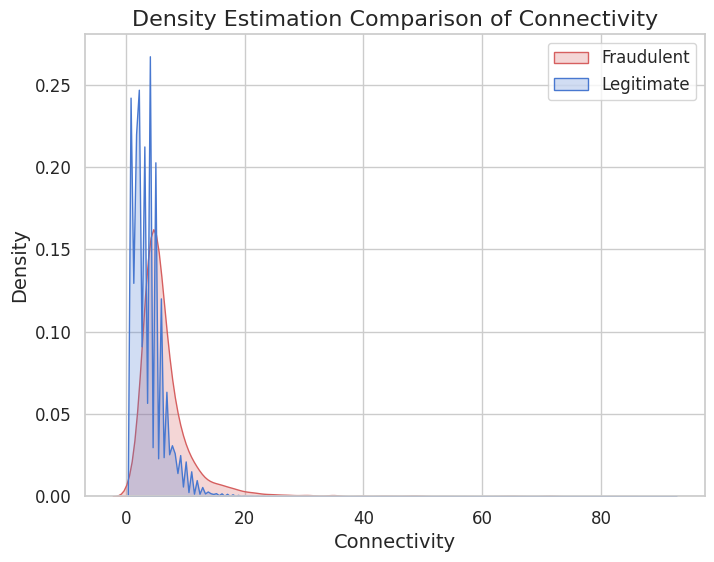

In [ ]:
plt.figure(figsize=(8, 6))
sns.kdeplot(data=fraudulent_nodes_df['Connectivity'],
            color=reddish_color,
            label='Fraudulent',
            shade=True)
sns.kdeplot(data=legitimate_nodes_df['Connectivity'],
            color=blueish_color,
            label='Legitimate',
            shade=True)

plt.title('Density Estimation Comparison of Connectivity')
plt.xlabel('Connectivity')
plt.ylabel('Density')
plt.legend()
plt.show()

**Statistical Tests**

In [ ]:
#T-test assuming equal variance
t_test_eq_var = stats.ttest_ind(legitimate_nodes_df['Connectivity'], fraudulent_nodes_df['Connectivity'])

print(f'The T-test on the overall connnectivity and ASSUMING variance is: {t_test_eq_var.pvalue:-5f}')

t_test_diff_var = stats.ttest_ind(legitimate_nodes_df['Connectivity'], fraudulent_nodes_df['Connectivity'], equal_var = False)

print(f'\nThe T-test on the overall connnectivity and NOT ASSUMING equal variance is: {t_test_eq_var.pvalue:-5f}')



The T-test on the overall connnectivity and ASSUMING variance is: 0.000000

The T-test on the overall connnectivity and NOT ASSUMING equal variance is: 0.000000


#### Connectivity Ratio Comparison; Fraudulent vs Legitimate Accounts

In [ ]:
fraudulent_nodes_df.head()

,Accounts,Transactions,Connectivity,Connectivity_Ratio
157195,8062D0260,1,1,1.0
488824,8134FC680,1,1,1.0
490858,8136547E0,1,1,1.0
704712,81C11C360,1,1,1.0
583626,81721EBD0,2,1,0.5


<ipython-input-114-6d21e0823a2c>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Type', y='Connectivity_Ratio', data=combined_df, palette=palette)


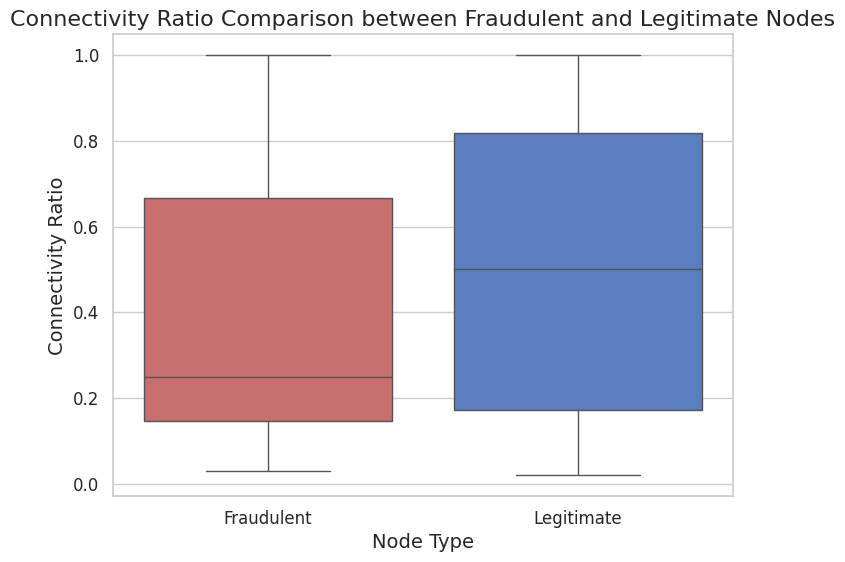

In [ ]:
# Create a lightweight combined DataFrame containing only the needed columns
combined_df = pd.concat([
    pd.DataFrame({'Connectivity_Ratio': fraudulent_nodes_df['Connectivity_Ratio'], 'Type': 'Fraudulent'}),
    pd.DataFrame({'Connectivity_Ratio': legitimate_nodes_df['Connectivity_Ratio'], 'Type': 'Legitimate'})
])

# Define a palette mapping for custom colors
palette = {
    'Fraudulent': reddish_color,  # e.g., (1.0, 0.2, 0.2) or any valid matplotlib color format
    'Legitimate': blueish_color     # e.g., (0.2, 0.4, 1.0)
}

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Connectivity_Ratio', data=combined_df, palette=palette)
plt.title('Connectivity Ratio Comparison between Fraudulent and Legitimate Nodes')
plt.xlabel('Node Type')
plt.ylabel('Connectivity Ratio')
plt.show()

del combined_df

<ipython-input-115-4aca0bbf7a06>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=fraudulent_nodes_df['Connectivity_Ratio'],
<ipython-input-115-4aca0bbf7a06>:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=legitimate_nodes_df['Connectivity_Ratio'],


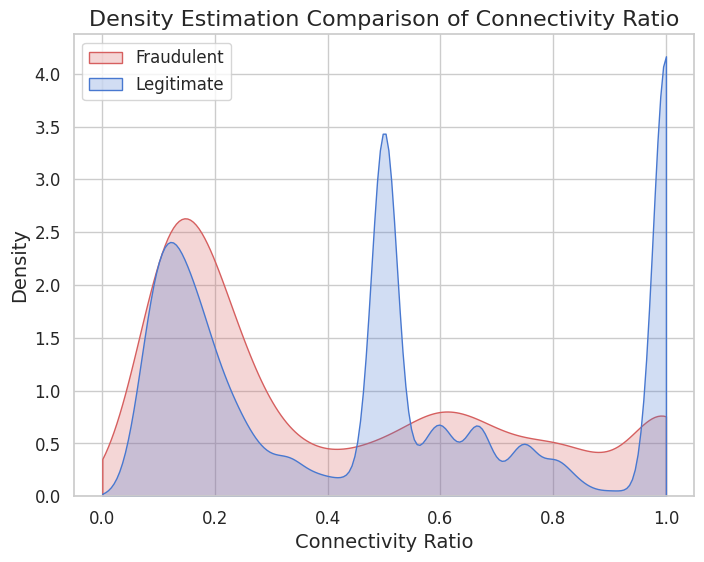

In [ ]:
plt.figure(figsize=(8, 6))

# Define the extrema (limits) for the underlying distributions
min_value = 0  # Adjust this based on your knowledge of the data
max_value = 1  # Adjust this based on your knowledge of the data

sns.kdeplot(data=fraudulent_nodes_df['Connectivity_Ratio'],
            color=reddish_color,
            label='Fraudulent',
            shade=True,
            clip=(min_value, max_value))

sns.kdeplot(data=legitimate_nodes_df['Connectivity_Ratio'],
            color=blueish_color,
            label='Legitimate',
            shade=True,
            clip=(min_value, max_value))

plt.title('Density Estimation Comparison of Connectivity Ratio')
plt.xlabel('Connectivity Ratio')
plt.ylabel('Density')
plt.legend()
plt.show()

**Statistical Tests**

In [ ]:
#T-test assuming equal variance
t_test_eq_var = stats.ttest_ind(legitimate_nodes_df['Connectivity_Ratio'], fraudulent_nodes_df['Connectivity_Ratio'])

print(f'The T-test on the overall connnectivity and ASSUMING variance is: {t_test_eq_var.pvalue:-5f}')

t_test_diff_var = stats.ttest_ind(legitimate_nodes_df['Connectivity_Ratio'], fraudulent_nodes_df['Connectivity_Ratio'], equal_var = False)

print(f'\nThe T-test on the overall connnectivity and NOT ASSUMING equal variance is: {t_test_eq_var.pvalue:-5f}')



The T-test on the overall connnectivity and ASSUMING variance is: 0.000000

The T-test on the overall connnectivity and NOT ASSUMING equal variance is: 0.000000


## Outlier Analysis

#### Fraudulent vs Legitimate Outlier Accounts

In [ ]:
outlier_accounts = outliers_df['Accounts'].unique()
outlier_accounts = set(outlier_accounts)

fraudulent_outlier_acconts = fraudulent_accounts.intersection(outlier_accounts)
legitimate_outlier_acconts = legitimate_accounts.intersection(outlier_accounts)

print(f'Among the outlier accounts {len(fraudulent_outlier_acconts)} or {len(fraudulent_outlier_acconts) / len(outlier_accounts)*100:.4f}%')
print(f'Among the outlier accounts {len(legitimate_outlier_acconts)} or {len(legitimate_outlier_acconts) / len(outlier_accounts)*100:.4f}%')

leg_percentage = (len(legitimate_outlier_acconts) / len(outlier_accounts))*100
fraud_percentage = (len(fraudulent_outlier_acconts) / len(outlier_accounts))*100


Among the outlier accounts 15 or 100.0000%
Among the outlier accounts 0 or 0.0000%


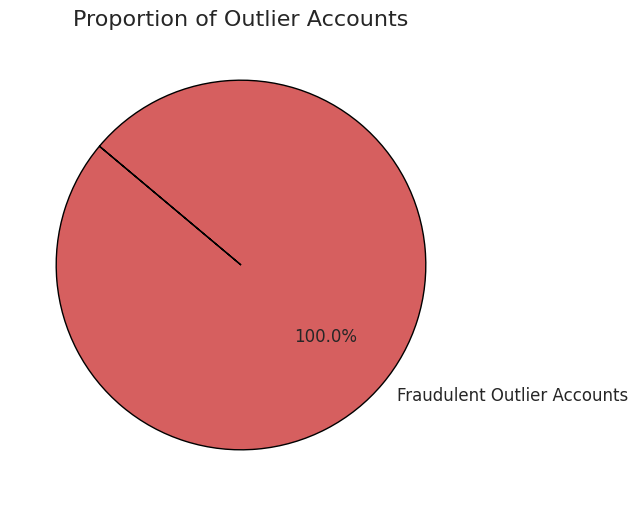

In [ ]:
# Compute percentages
leg_percentage = (len(legitimate_outlier_acconts) / len(outlier_accounts)) * 100
fraud_percentage = (len(fraudulent_outlier_acconts) / len(outlier_accounts)) * 100

# Filter out zero values
labels = []
sizes = []
colors = []

if leg_percentage > 0:
    labels.append('Legitimate Outlier Accounts')
    sizes.append(leg_percentage)
    colors.append(blueish_color)

if fraud_percentage > 0:
    labels.append('Fraudulent Outlier Accounts')
    sizes.append(fraud_percentage)
    colors.append(reddish_color)

# Create the pie chart only if there's at least one nonzero category
if sizes:
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140, wedgeprops={'edgecolor': 'black'})
    plt.title('Proportion of Outlier Accounts')
    plt.show()
else:
    print("No outlier accounts to display.")

### Presence in Fraudulent Patterns

In [ ]:
type_frauds = list(data[data['type_fraud'].notna()]['type_fraud'].unique())
# print(type_frauds)
# print(type(type_frauds))

columns = ['n_transactions', 'n_different_frauds'] + type_frauds

# print(columns)

outlier_stats_df = pd.DataFrame(columns = columns)

# print(outlier_stats_df)

In [ ]:
for test_account in outlier_accounts:

    account_activity = data[(data['Account'] == test_account) | (data['Account.1'] == test_account)]

    tot_transactions = len(account_activity)

    frauds_id = account_activity[account_activity['fraud_id'].notna()]['fraud_id'].unique()

    outlier_different_frauds[test_account] = frauds_id

    print(f'The {test_account} engages in {len(frauds_id)} different frauds')


    type_fraud_counts = account_activity['type_fraud'].value_counts().to_dict()

    row_data = {'n_transactions': tot_transactions, 'n_different_frauds': len(frauds_id)}

    for fraud_type in type_frauds:
        row_data[fraud_type] = type_fraud_counts.get(fraud_type, 0)  # Default to 0 if fraud type not found

    # Append the row to the DataFrame
    outlier_stats_df = pd.concat([outlier_stats_df, pd.DataFrame([row_data])], ignore_index=True)


The 10042B780 engages in 32 different frauds
The 10042B858 engages in 27 different frauds
The 10042B8A0 engages in 25 different frauds
The 10042B8E8 engages in 11 different frauds
The 10042B6F0 engages in 48 different frauds
The 10042B660 engages in 314 different frauds
The 10042B738 engages in 28 different frauds
The 10042B810 engages in 18 different frauds
The 10042B6A8 engages in 196 different frauds
The 10042B930 engages in 19 different frauds
The 10042B7C8 engages in 12 different frauds
The 10042B9C0 engages in 29 different frauds
The 10042BA08 engages in 39 different frauds
The 10042B978 engages in 21 different frauds
The 10042BA51 engages in 31 different frauds


In [ ]:
outlier_stats_df.index = outlier_accounts

outlier_stats_df.sort_values(by = 'n_transactions', ascending = False)

outlier_stats_df['percentage_transactions'] = (outlier_stats_df['n_transactions'] / len(data)) * 100

unique_frauds = len(data[data['fraud_id'].notna()]['fraud_id'].unique())

outlier_stats_df['percentage_different_frauds'] = (outlier_stats_df['n_different_frauds'] / unique_frauds) * 100


In [ ]:
outlier_stats_df

,n_transactions,n_different_frauds,UNSPECIFIED,FAN-IN,GATHER-SCATTER,RANDOM,SCATTER-GATHER,FAN-OUT,STACK,CYCLE,BIPARTITE,percentage_transactions,percentage_different_frauds
10042B780,31025,32,32,0,0,0,0,0,0,0,0,0.448076,355.555556
10042B858,15814,27,27,0,0,0,0,0,0,0,0,0.228392,300.0
10042B8A0,19414,25,25,0,0,0,0,0,0,0,0,0.280385,277.777778
10042B8E8,7801,11,11,0,0,0,0,0,0,0,0,0.112665,122.222222
10042B6F0,42730,48,48,0,0,0,0,0,0,0,0,0.617124,533.333333
10042B660,223590,314,314,0,0,0,0,0,0,0,0,3.22918,3488.888889
10042B738,18348,28,28,0,0,0,0,0,0,0,0,0.264989,311.111111
10042B810,8213,18,18,0,0,0,0,0,0,0,0,0.118616,200.0
10042B6A8,139728,196,196,0,0,0,0,0,0,0,0,2.01801,2177.777778
10042B930,19576,19,19,0,0,0,0,0,0,0,0,0.282725,211.111111


In [ ]:
outlier_stats_df.columns

Index(['n_transactions', 'n_different_frauds', 'UNSPECIFIED', 'FAN-IN',
       'GATHER-SCATTER', 'RANDOM', 'SCATTER-GATHER', 'FAN-OUT', 'STACK',
       'CYCLE', 'BIPARTITE', 'percentage_transactions',
       'percentage_different_frauds'],
      dtype='object')

In [ ]:
column_order = ['n_transactions', 'percentage_transactions', 'n_different_frauds',
                'percentage_different_frauds', 'UNSPECIFIED', 'FAN-IN',
                'GATHER-SCATTER', 'RANDOM', 'SCATTER-GATHER', 'FAN-OUT', 'STACK',
                'CYCLE', 'BIPARTITE']

outlier_stats_df = outlier_stats_df[column_order]

outlier_stats_df

,n_transactions,percentage_transactions,n_different_frauds,percentage_different_frauds,UNSPECIFIED,FAN-IN,GATHER-SCATTER,RANDOM,SCATTER-GATHER,FAN-OUT,STACK,CYCLE,BIPARTITE
10042B780,31025,0.448076,32,1.20346,32,0,0,0,0,0,0,0,0
10042B858,15814,0.228392,27,1.015419,27,0,0,0,0,0,0,0,0
10042B8A0,19414,0.280385,25,0.940203,25,0,0,0,0,0,0,0,0
10042B8E8,7801,0.112665,11,0.413689,11,0,0,0,0,0,0,0,0
10042B6F0,42730,0.617124,48,1.80519,48,0,0,0,0,0,0,0,0
10042B660,223590,3.22918,314,11.808951,314,0,0,0,0,0,0,0,0
10042B738,18348,0.264989,28,1.053027,28,0,0,0,0,0,0,0,0
10042B810,8213,0.118616,18,0.676946,18,0,0,0,0,0,0,0,0
10042B6A8,139728,2.01801,196,7.371192,196,0,0,0,0,0,0,0,0
10042B930,19576,0.282725,19,0.714554,19,0,0,0,0,0,0,0,0


In [ ]:
tot_by_fraud = data[data['type_fraud'].notna()]['type_fraud'].value_counts()

total = outlier_stats_df.loc[:,type_frauds].sum().rename('Number')

percentage = ((outlier_stats_df.loc[:,type_frauds].sum() / tot_by_fraud)*100).rename('Percentage')

outlier_type_fraud_stats = pd.merge(total, percentage, how = 'left', left_index = True, right_index = True)
outlier_type_fraud_stats

,Number,Percentage
UNSPECIFIED,850,33.438238
FAN-IN,0,0.0
GATHER-SCATTER,0,0.0
RANDOM,0,0.0
SCATTER-GATHER,0,0.0
FAN-OUT,0,0.0
STACK,0,0.0
CYCLE,0,0.0
BIPARTITE,0,0.0


In [ ]:
def plot_percentage_pie(column, title = '', single = False):

    if single:
      if column > 1:
        column = column / 100

      total_percentage = column

    else:
      # Convert column to float (in case of string percentages)
      column = column.astype(float)

      # Step 1: Sum the percentages
      total_percentage = column.sum() / 100  # Convert back to [0,1] scale

    # Step 2: Compute the remaining percentage
    remaining_percentage = 1 - total_percentage

    # Ensure values are within valid range
    total_percentage = max(0, min(1, total_percentage))
    remaining_percentage = max(0, min(1, remaining_percentage))

    # Labels and values for the pie chart
    labels = ['Outlier Accounts', 'Remaining']
    values = [total_percentage, remaining_percentage]
    colors = [reddish_color, blueish_color]

    # Step 3: Plot the pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(values, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140, wedgeprops={'edgecolor': 'black'})
    plt.title(f"Outlier impact on {title}")
    plt.show()

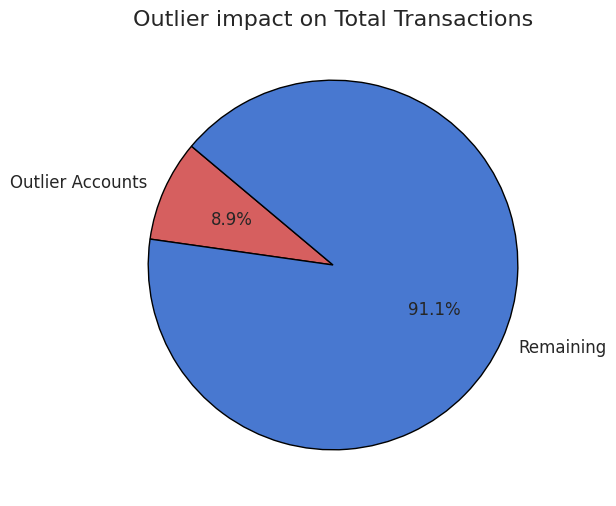

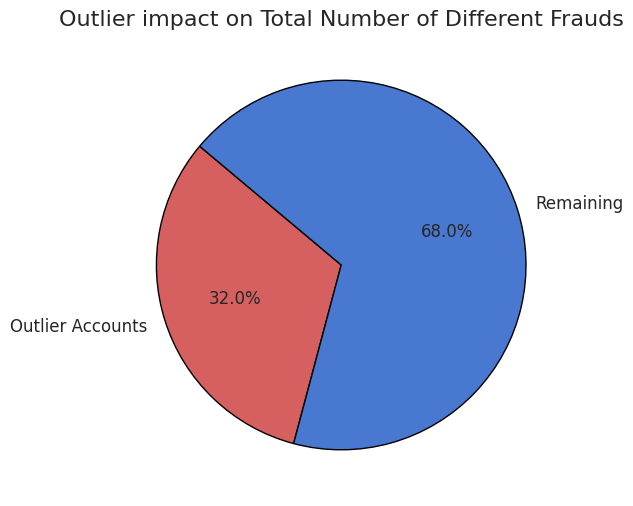

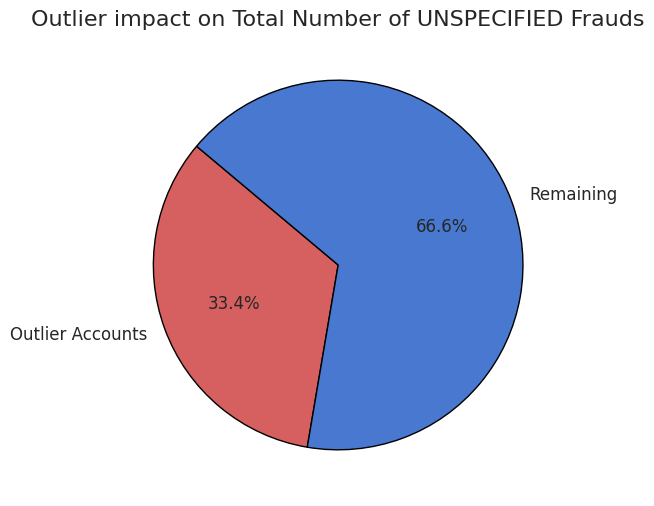

In [ ]:
plot_percentage_pie(outlier_stats_df['percentage_transactions'], title = 'Total Transactions')

plot_percentage_pie(outlier_stats_df['percentage_different_frauds'], title = 'Total Number of Different Frauds')

plot_percentage_pie(outlier_type_fraud_stats.loc['UNSPECIFIED','Percentage'], title = 'Total Number of UNSPECIFIED Frauds', single = True)

### Impact on connectivity

In [ ]:
total_edges = account_graph.number_of_edges()
print(f"Total number of edges: {total_edges}")

Total number of edges: 1380011


In [ ]:
edge_number_list = []
for account in list(outlier_stats_df.index):

  account_edges = account_graph.degree[account]
  print(f"Number of edges for {account}: {account_edges}")

  edge_number_list.append(account_edges)

outlier_stats_df['Edges'] = edge_number_list

Number of edges for 10042B780: 2738
Number of edges for 10042B858: 1404
Number of edges for 10042B8A0: 1718
Number of edges for 10042B8E8: 693
Number of edges for 10042B6F0: 3787
Number of edges for 10042B660: 19727
Number of edges for 10042B738: 1630
Number of edges for 10042B810: 748
Number of edges for 10042B6A8: 12355
Number of edges for 10042B930: 1661
Number of edges for 10042B7C8: 678
Number of edges for 10042B9C0: 1418
Number of edges for 10042BA08: 2014
Number of edges for 10042B978: 1079
Number of edges for 10042BA51: 2516


In [ ]:
outlier_stats_df['percentage_edges'] = (outlier_stats_df['Edges'] / total_edges) * 100

In [ ]:
outlier_stats_df['percentage_edges']

,percentage_edges
10042B780,0.198404
10042B858,0.101738
10042B8A0,0.124492
10042B8E8,0.050217
10042B6F0,0.274418
10042B660,1.429481
10042B738,0.118115
10042B810,0.054202
10042B6A8,0.895283
10042B930,0.120361


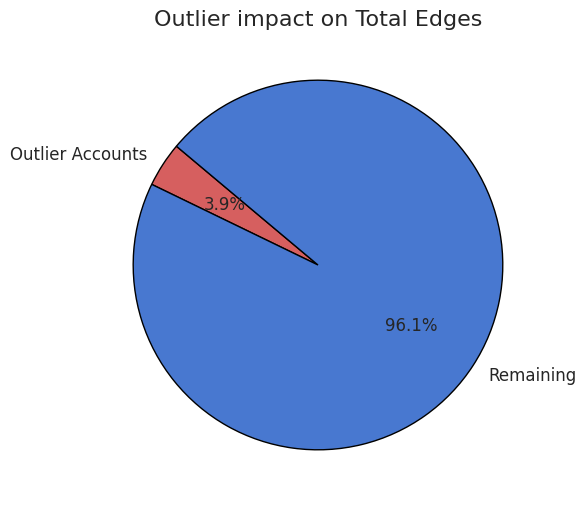

In [ ]:
plot_percentage_pie(outlier_stats_df['percentage_edges'], title = 'Total Edges')

# Bank Graph Analysis
---

In [ ]:
data.head()

In [ ]:
st = time.time()
# Create an undirected graph from your DataFrame
bank_graph = nx.from_pandas_edgelist(data, source='From Bank', target= 'To Bank')

# Compute connectivity: the number of unique neighbors (interactions) for each account
bank_connectivity = dict(bank_graph.degree())

bank_connectivity_df = pd.DataFrame(list(bank_connectivity.items()), columns=['Bank', 'Connectivity'])


connectivity_df = pd.DataFrame(list(bank_connectivity.items()), columns=['Bank', 'Connectivity'])

et = time.time()

print(f'Total time is: {et - st:.2f}')

In [ ]:
connectivity_df.head()

In [ ]:
data.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,type_fraud,fraud_id,pattern_number,depth_info,depht_type_info
0,2022-09-01,1807,801321C30,1807,801321C30,220579.84,US Dollar,220579.84,US Dollar,Reinvestment,0,NaN,NaN,NaN,NaN,NaN
1,2022-09-01,16679,80B2E1890,217798,80BDED1B0,3067.32,US Dollar,3067.32,US Dollar,Credit Card,0,NaN,NaN,NaN,NaN,NaN
2,2022-09-01,213504,80A0867A0,213504,80A0867A0,437443.44,Yuan,437443.44,Yuan,Reinvestment,0,NaN,NaN,NaN,NaN,NaN
3,2022-09-01,319147,818B0F480,319147,818B0F480,14877.50,Euro,14877.50,Euro,Reinvestment,0,NaN,NaN,NaN,NaN,NaN
4,2022-09-01,111913,809E0ABE0,111913,809E0ABE0,15.85,US Dollar,15.85,US Dollar,Reinvestment,0,NaN,NaN,NaN,NaN,NaN


In [ ]:
data['Payment Currency'].unique()

array(['US Dollar', 'Yuan', 'Euro', 'Bitcoin', 'Yen', 'Canadian Dollar',
       'Brazil Real', 'Saudi Riyal', 'UK Pound', 'Shekel',
       'Australian Dollar', 'Swiss Franc', 'Rupee', 'Ruble',
       'Mexican Peso'], dtype=object)

# Memory Analysis

In [110]:
import sys

def list_global_vars_by_shallow_size():
    variable_info = []
    # Iterate through items in the global namespace
    for name, var in globals().items():
        # Filter out built-in/system variables
        if name.startswith("__"):
            continue
        try:
            size = sys.getsizeof(var)
        except Exception:
            size = 0
        variable_info.append((name, type(var), size))

    # Sort the variables by size (largest first)
    variable_info.sort(key=lambda x: x[2], reverse=True)

    # Display the results
    print("Global variables sorted by shallow size:")
    for name, var_type, size in variable_info[:15]:
        print(f"{name}: {size} bytes, type: {var_type}")

# Run the function
list_global_vars_by_shallow_size()

Global variables sorted by shallow size:
data: 3471099682 bytes, type: <class 'pandas.core.frame.DataFrame'>
x: 3243504 bytes, type: <class 'pandas.core.series.Series'>
_22: 4764 bytes, type: <class 'pandas.core.series.Series'>
_i4: 3170 bytes, type: <class 'str'>
_i51: 3170 bytes, type: <class 'str'>
_i56: 3170 bytes, type: <class 'str'>
_i60: 3170 bytes, type: <class 'str'>
forex_df: 2764 bytes, type: <class 'pandas.core.frame.DataFrame'>
forex_df_reindexed: 2764 bytes, type: <class 'pandas.core.frame.DataFrame'>
forex_df_filled: 2764 bytes, type: <class 'pandas.core.frame.DataFrame'>
_15: 2764 bytes, type: <class 'pandas.core.frame.DataFrame'>
_69: 2764 bytes, type: <class 'pandas.core.frame.DataFrame'>
_i3: 2697 bytes, type: <class 'str'>
_i50: 2697 bytes, type: <class 'str'>
_i55: 2697 bytes, type: <class 'str'>


In [111]:
del x

In [112]:
# Get all variables
vars_dict = {name: sys.getsizeof(value) for name, value in globals().items()}

# Convert to DataFrame for easy sorting
df = pd.DataFrame(vars_dict.items(), columns=["Variable", "Size (bytes)"])
df = df.sort_values(by="Size (bytes)", ascending=False)

In [113]:
df

,Variable,Size (bytes)
53,data,3471099682
82,_22,4764
43,_i4,3170
131,_i51,3170
140,_i60,3170
...,...,...
57,st,24
100,et,24
2,__package__,16
3,__loader__,16
